In [2]:
from pathlib import Path
import json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    auc
)
from functools import wraps
from typing import Iterable
from collections import defaultdict

seed = 1234
n_bs = 20
rng = np.random.default_rng(seed)

def bootstrap_metric(metric: callable, rng: np.random.Generator, n_bootstraps: int = 20) -> callable:
    """Bootstrap a metric calculation.

    Args:
        y_true (np.ndarray): True binary labels.
        y_pred_or_probas (np.ndarray): Predicted binary labels or probabilities.
        metric (callable): Metric function to be bootstrapped. Should take y_true and y_pred as arguments.
        threshold (float, optional): Threshold to convert probabilities to binary labels. If None, y_pred_or_probas is assumed to be binary labels. Defaults to None.
        n_bootstraps (int, optional): Number of bootstrap samples. Defaults to 20.

    Returns:
        callable: A function that computes the bootstrapped metric and its 95% confidence interval.
    """
    @wraps(metric)
    def wrapper(y_true: Iterable[int], y_pred_or_probas: Iterable[float | int], threshold: float | None = None, n_bootstraps: int = n_bootstraps, rng: np.random.Generator = rng, *args, **kwargs) -> tuple[float, tuple[float, float]]:
        boot_metrics = []
        n = len(y_true)
        for _ in range(n_bootstraps):
            indices = rng.integers(0, n, n)
            if threshold is not None:
                y_pred_sample = (y_pred_or_probas[indices] >= threshold).astype(int)
            else:
                y_pred_sample = y_pred_or_probas[indices]
            y_true_sample = y_true[indices]
            boot_metric = metric(y_true_sample, y_pred_sample, *args, **kwargs)
            boot_metrics.append(boot_metric)
        boot_metrics = np.array(boot_metrics)
        mean_metric = np.mean(boot_metrics)
        lower_ci = np.percentile(boot_metrics, 2.5)
        upper_ci = np.percentile(boot_metrics, 97.5)
        return mean_metric, (lower_ci, upper_ci)
    return wrapper


def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

discrete_metrics = {
    'f1': bootstrap_metric(f1_score, rng, n_bootstraps=n_bs),
    'binary_precision': bootstrap_metric(precision_score, rng, n_bootstraps=n_bs),
    'binary_recall': bootstrap_metric(recall_score, rng, n_bootstraps=n_bs),
    'accuracy': bootstrap_metric(accuracy_score, rng, n_bootstraps=n_bs),
}

continuous_metrics = {
    'roc_auc': bootstrap_metric(roc_auc_score, rng, n_bootstraps=n_bs),
}

def get_nm_indices(df: pd.DataFrame, neg_multiple: int, seed: int = seed) -> np.ndarray:
    _rng = np.random.default_rng(seed)
    neg_idxs = df[df['y'] == 0].index
    n_to_rm = len(neg_idxs) - (len(df[df['y'] == 1]) * neg_multiple)
 
    if n_to_rm <= 0:
        return np.array(df.index)
    n_to_keep = len(neg_idxs) - n_to_rm
    keep_idxs = _rng.choice(neg_idxs, size=n_to_keep, replace=False)
    all_idxs = np.concatenate((df[df['y'] == 1].index.to_numpy(), keep_idxs))
    return all_idxs

Wrangle top model run ids

In [3]:
top_models = pd.read_csv(Path(filepaths.artifacts) / "250209_top_models.csv", sep=',')
top_cgr = pd.read_csv(Path(filepaths.artifacts) / "250223_top_cgr_models.csv", sep=',')
second_wave = pd.read_csv(Path(filepaths.artifacts) / "251015_non_clip_v2_split_models.csv", sep=',')
second_wave = second_wave.loc[second_wave['data/split_idx'] == -1]
non_clip = pd.concat((top_models, top_cgr, second_wave), axis=0, ignore_index=True)
non_clip.head()

Start Time Duration                            Run ID  \
0  2025-02-07 13:21:04     3.9h  ff90895a6070499b8fdcdc0982526885   
1  2025-02-07 13:20:39     3.1h  8a155bc5673b4c6aa8667dd55755fe0b   
2  2025-02-07 13:20:39     3.1h  5ca6ba7b8aec4b81a366e9138b9c09b0   
3  2025-02-07 13:20:35     3.4h  2241478505f9497885d25b9a0dee3ffd   
4  2025-02-07 13:20:33     3.4h  e638683b53f84d0ba1c8f32794413e0e   

                  Name Source Type  \
0     dazzling-rat-180       LOCAL   
1      zealous-eel-839       LOCAL   
2     smiling-colt-432       LOCAL   
3  fortunate-panda-724       LOCAL   
4       burly-goat-264       LOCAL   

                                         Source Name     User    Status  \
0  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
1  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
2  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
3  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
4  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   

   X_d_transform batch_norm  ... val/accuracy val/binary_precision  \
0            NaN       True  ...     0.809866             0.963687   
1            NaN       True  ...     0.809679             0.972779   
2            NaN       True  ...     0.797277             0.969662   
3            NaN       True  ...     0.950560             0.979499   
4            NaN       True  ...     0.949125             0.977389   

   val/binary_recall    val/f1   val/mcc   val/prc   val/roc  val_loss  \
0           0.631624  0.762649  0.653961  0.921851  0.912527  0.762649   
1           0.624411  0.760160  0.656536  0.959718  0.961152  0.760160   
2           0.600536  0.741214  0.635536  0.947565  0.949833  0.741214   
3           0.919235  0.948325  0.902712  0.986876  0.986808  0.948325   
4           0.918329  0.946844  0.899774  0.984206  0.986065  0.946844   

  data/negative_sampling  reduce_X_d  
0                    NaN         NaN  
1                    NaN         NaN  
2                    NaN         NaN  
3                    NaN         NaN  
4                    NaN         NaN  

[5 rows x 52 columns]

In [4]:
id2name = {
    row['Run ID']: {'data': row['data/split_strategy'], 'model': row['model/name']}
    for _, row in non_clip.iterrows()
}

id2name['clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold'] = {'data': 'rcmcs', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_drfp_outer_fold'] = {'data': 'drfp', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_esm_outer_fold'] = {'data': 'esm', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold'] = {'data': 'random_reaction', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme'}

In [5]:
best_thresholds = {}
for id in id2name.keys():
    if not (Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {id2name[id]}, skipping...")
        continue
    
    with open(Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[id] = {int(k): v for k, v in this.items()}


No thresholds saved for {'data': 'blosum', 'model': 'rc_agg'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'rc_cxn'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'mfp'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'drfp'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'bom'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'cgr'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'rc_cxn'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'bom'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'rc_agg'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'mfp'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'drfp'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'cgr'}, skipping...


In [84]:
preds = {} # Model outputs
nm_keep_indices = {} # Downsampled indices
chance = {}
cols = ['data', 'model', 'neg_multiple', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
evals = []
for id in best_thresholds.keys():
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output
    keep_indices = {
        nm : get_nm_indices(target_output, neg_multiple=nm, seed=seed)
        for nm in best_thresholds[id].keys()
    }

    nm_keep_indices[id] = keep_indices
    for nm in best_thresholds[id].keys():
        th = best_thresholds[id][nm]
        keep_idx = nm_keep_indices[id][nm]
        _target_output = target_output.loc[keep_idx]
        for metric_name, discrete_metric in discrete_metrics.items():
            mean, (ci_l, ci_u) = discrete_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy(), threshold=th)
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

        for metric_name, continuous_metric in continuous_metrics.items():
            mean, (ci_l, ci_u) = continuous_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy())
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

metrics_table = pd.DataFrame(
    evals, columns=cols
)

for _, row in metrics_table.drop_duplicates(['data', 'neg_multiple']).iterrows():
    _target_output = preds[row['id']].loc[nm_keep_indices[row['id']][row['neg_multiple']]]
    for metric in discrete_metrics.keys():
        mean, (ci_l, ci_u) = discrete_metrics[metric](_target_output['y'].to_numpy(), rng.integers(0, 2, size=len(_target_output)))
        chance[(row['data'], row['neg_multiple'], metric)] = mean

metrics_table.head()

data model  neg_multiple            metric      mean  ci_lower  ci_upper  \
0  rcmcs   bom             1                f1  0.947842  0.943778  0.952063   
1  rcmcs   bom             1  binary_precision  0.938260  0.934804  0.942722   
2  rcmcs   bom             1     binary_recall  0.960084  0.955802  0.966252   
3  rcmcs   bom             1          accuracy  0.946152  0.942825  0.949180   
4  rcmcs   bom             1           roc_auc  0.984072  0.982124  0.986002   

                                 id  
0  ff90895a6070499b8fdcdc0982526885  
1  ff90895a6070499b8fdcdc0982526885  
2  ff90895a6070499b8fdcdc0982526885  
3  ff90895a6070499b8fdcdc0982526885  
4  ff90895a6070499b8fdcdc0982526885

In [7]:
for gb in metrics_table.groupby(['data', 'neg_multiple', 'metric']):
    print(gb[0])
    print(gb[1][['model', 'mean', 'ci_lower', 'ci_upper']].to_markdown())
    print()

('drfp', np.int64(1), 'accuracy')
|     | model    |     mean |   ci_lower |   ci_upper |
|----:|:---------|---------:|-----------:|-----------:|
| 443 | rc_agg   | 0.932526 |   0.930142 |   0.935224 |
| 463 | rc_cxn   | 0.945549 |   0.943131 |   0.947961 |
| 483 | bom      | 0.928251 |   0.924902 |   0.930469 |
| 523 | drfp     | 0.896531 |   0.890796 |   0.900703 |
| 543 | mfp      | 0.904412 |   0.901767 |   0.907961 |
| 643 | cgr      | 0.938886 |   0.935883 |   0.941573 |
| 703 | clipzyme | 0.929621 |   0.926055 |   0.933308 |

('drfp', np.int64(1), 'binary_precision')
|     | model    |     mean |   ci_lower |   ci_upper |
|----:|:---------|---------:|-----------:|-----------:|
| 441 | rc_agg   | 0.938815 |   0.935262 |   0.943065 |
| 461 | rc_cxn   | 0.941178 |   0.936471 |   0.945944 |
| 481 | bom      | 0.92564  |   0.921256 |   0.930811 |
| 521 | drfp     | 0.956963 |   0.95153  |   0.960441 |
| 541 | mfp      | 0.95021  |   0.945598 |   0.954722 |
| 641 | cgr      | 0.938794

# Plotting

In [ ]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

get_model_order = lambda x : [list(labels.keys()).index(elt) for elt in x]

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

metrics = {
    'f1': f1_score,
    'binary_precision': precision_score,
    'binary_recall': recall_score,
    'accuracy': accuracy_score
}

metric_names = {
    'f1': "F1",
    'binary_precision': "Precision",
    'binary_recall': "Recall",
    'accuracy': "Accuracy",
}

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
    'drfp': "DRFP",
    'esm': "ESM",
    'random_reaction': "Random reaction",
    'random_reaction_center': "Random reaction center",
    'gsi': "GSI <25%"
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 16,
})

ROC curves

In [47]:
figsize = (10, 5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

DRFP - Negative multiple 1


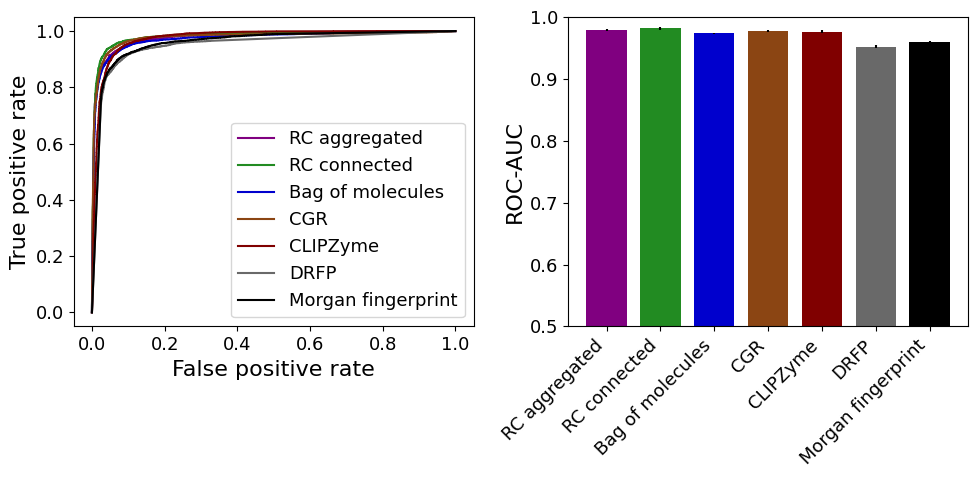

DRFP - Negative multiple 3


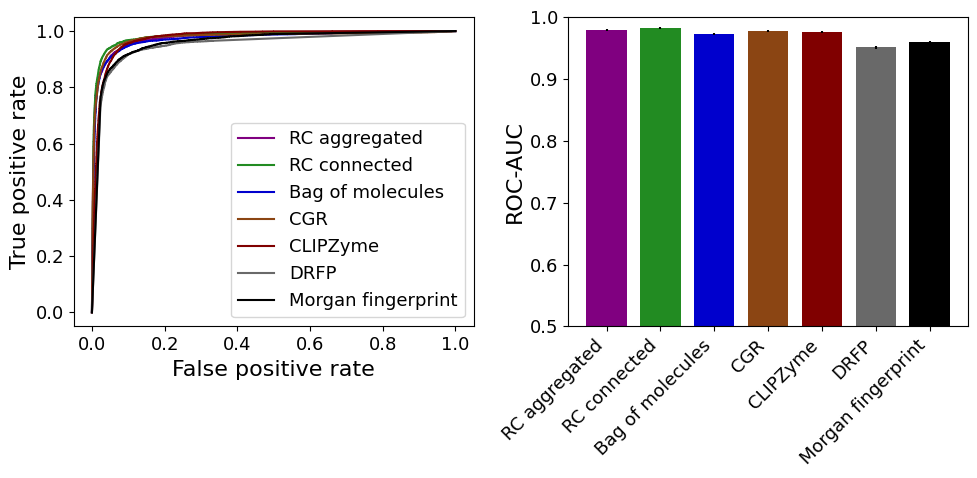

DRFP - Negative multiple 5


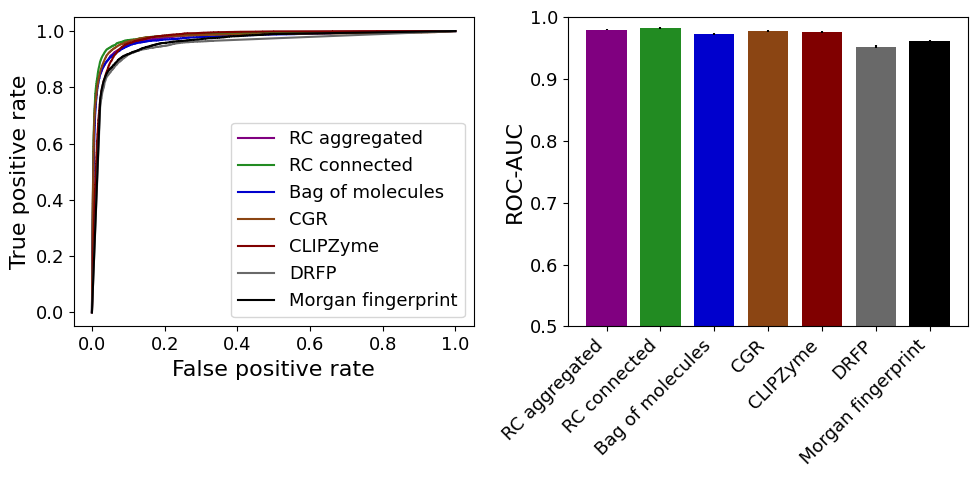

DRFP - Negative multiple 10


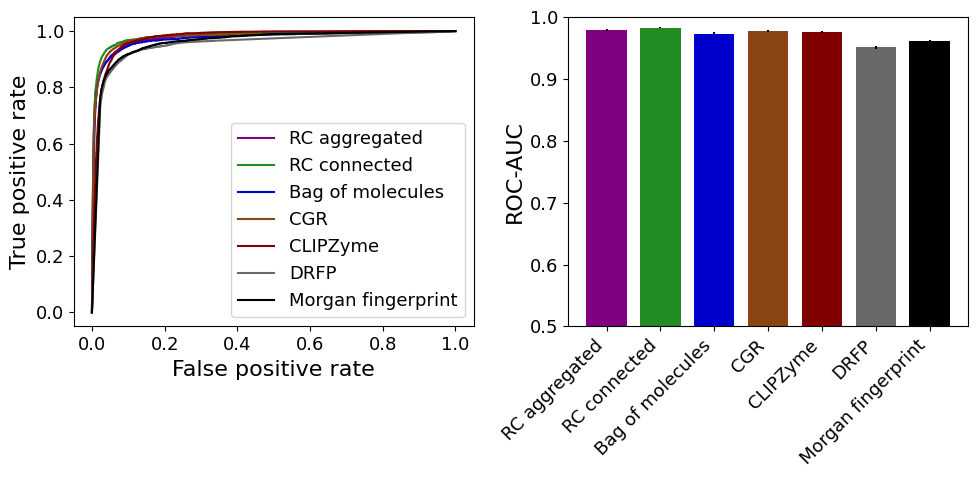

ESM - Negative multiple 1


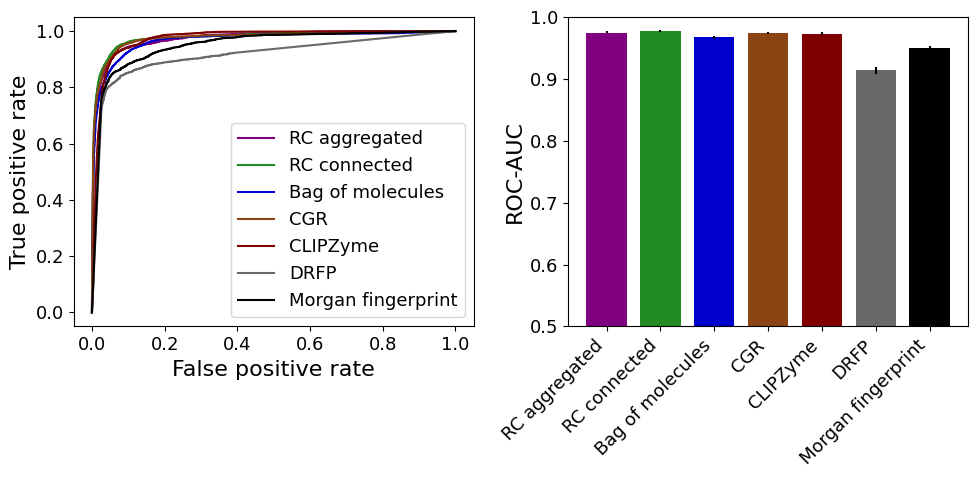

ESM - Negative multiple 3


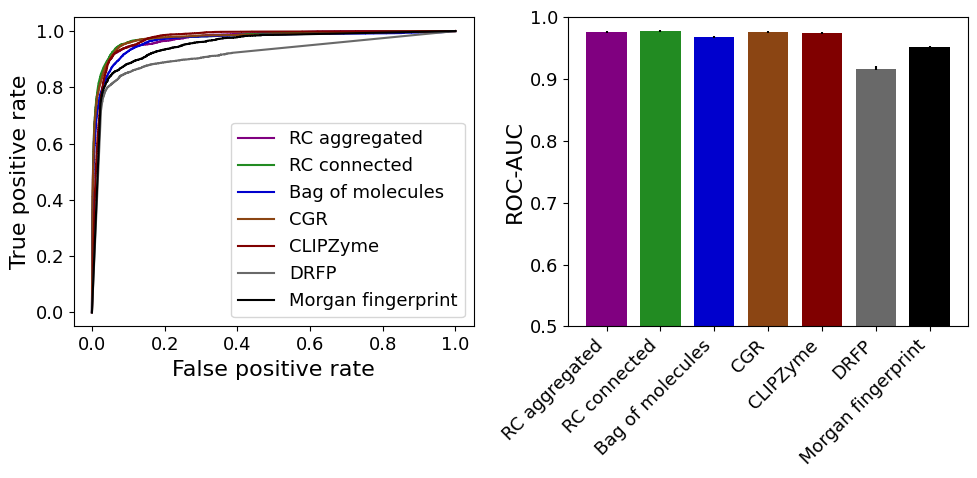

ESM - Negative multiple 5


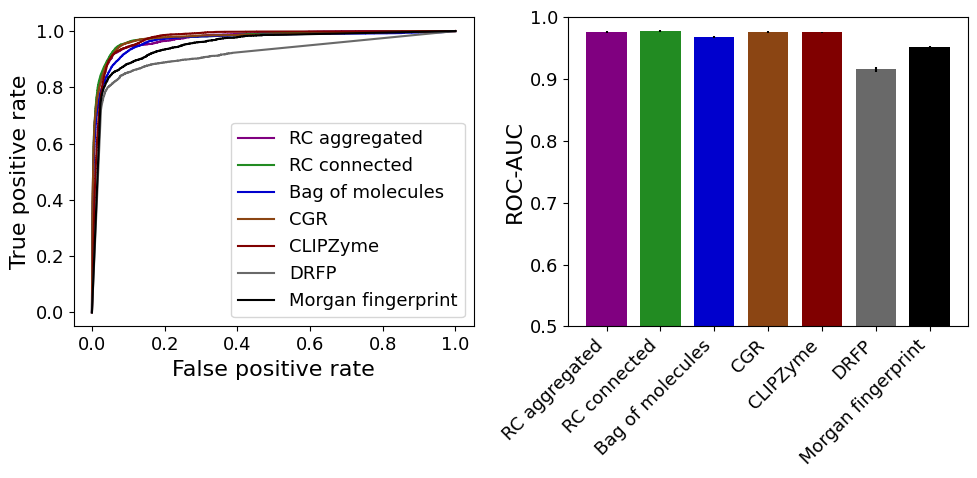

ESM - Negative multiple 10


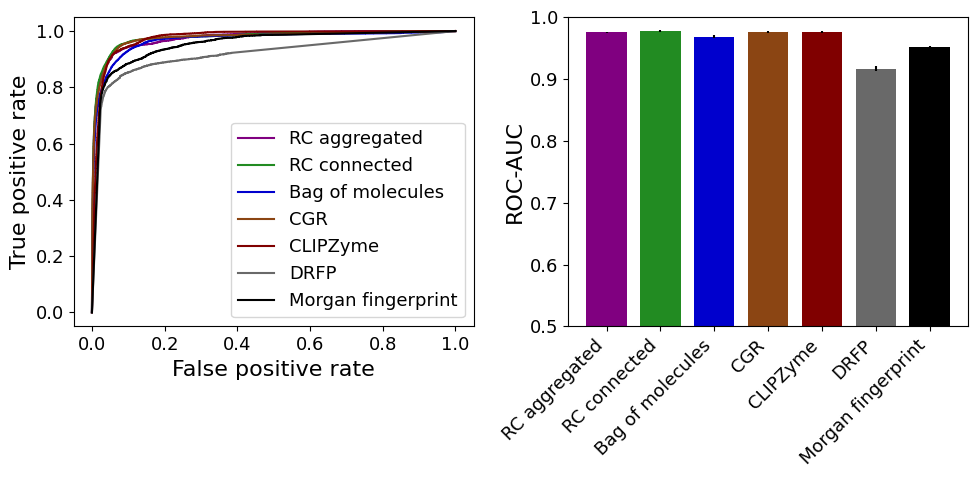

GSI - Negative multiple 1


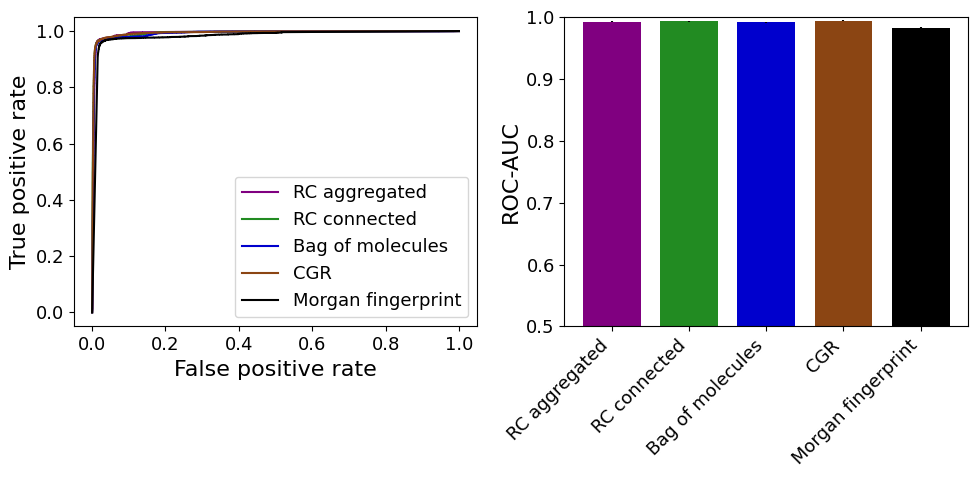

GSI - Negative multiple 3


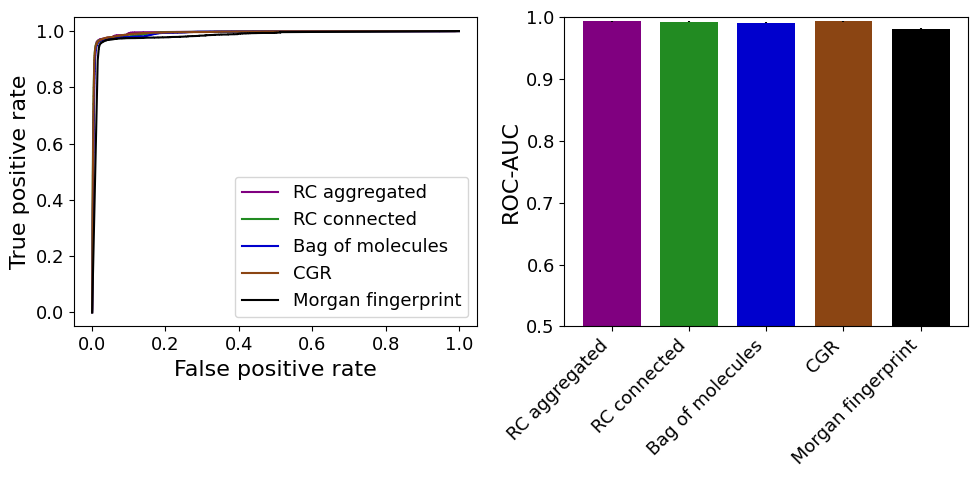

GSI - Negative multiple 5


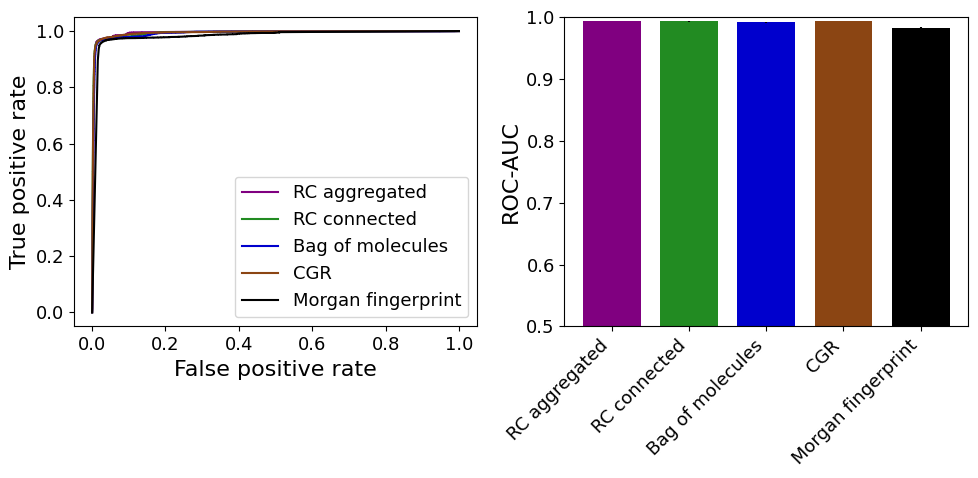

GSI - Negative multiple 10


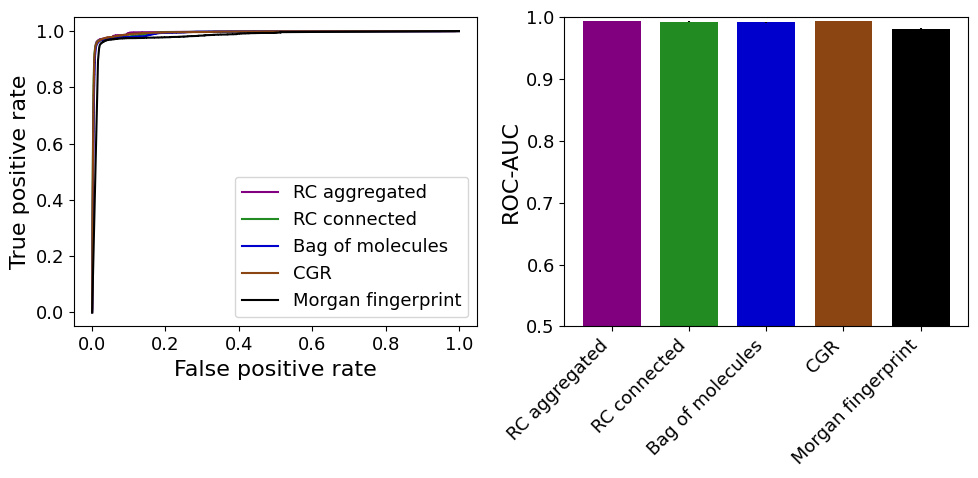

Random reaction - Negative multiple 1


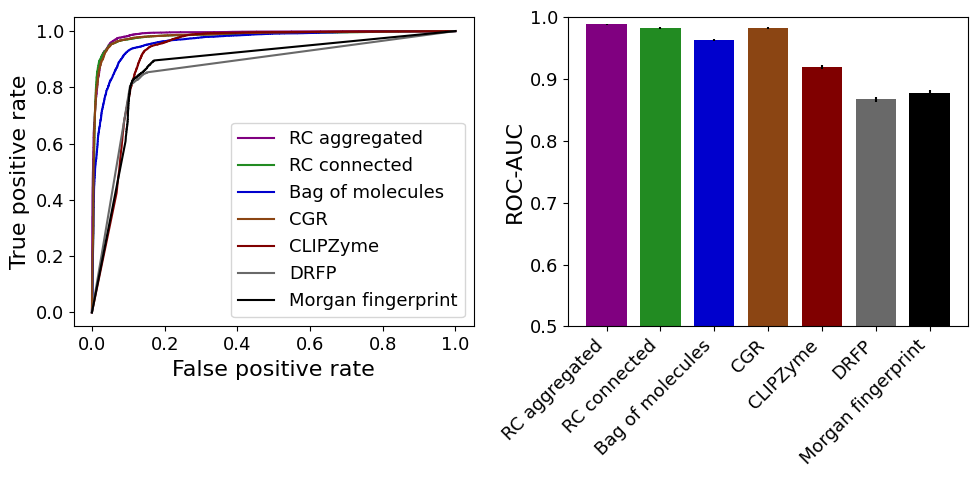

Random reaction - Negative multiple 3


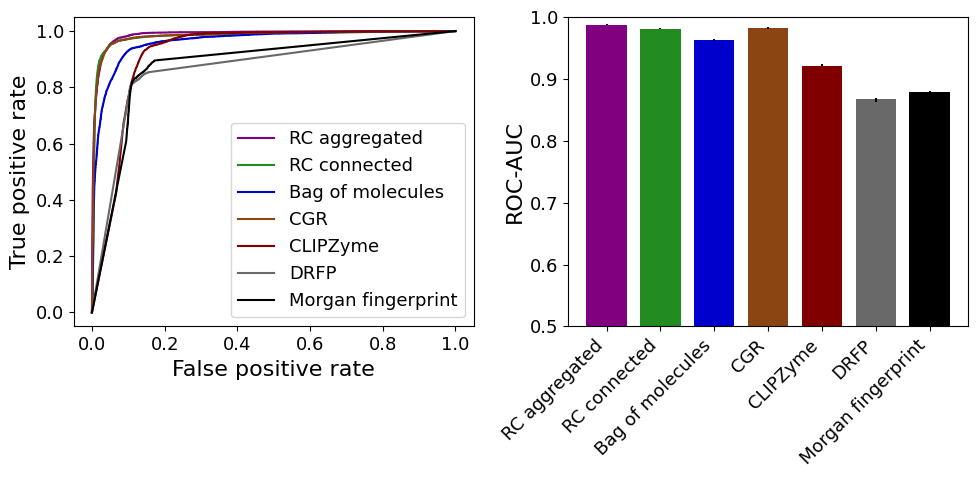

Random reaction - Negative multiple 5


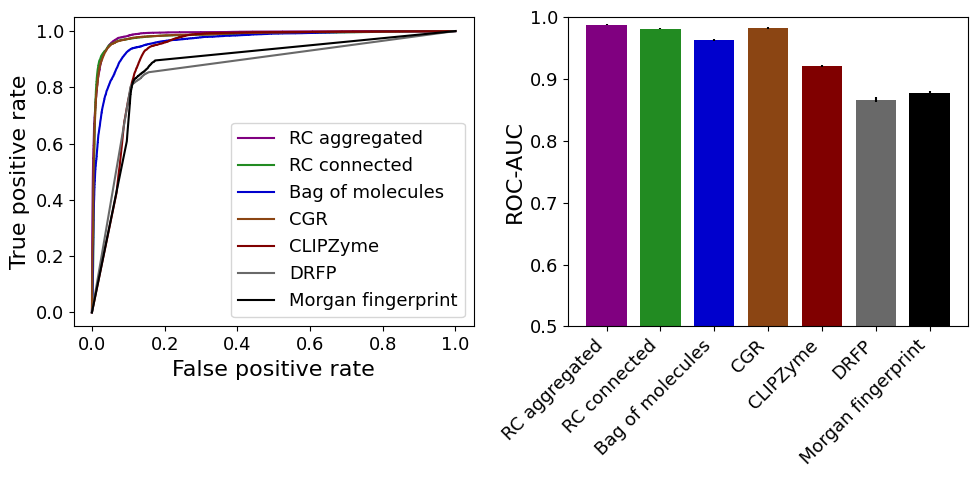

Random reaction - Negative multiple 10


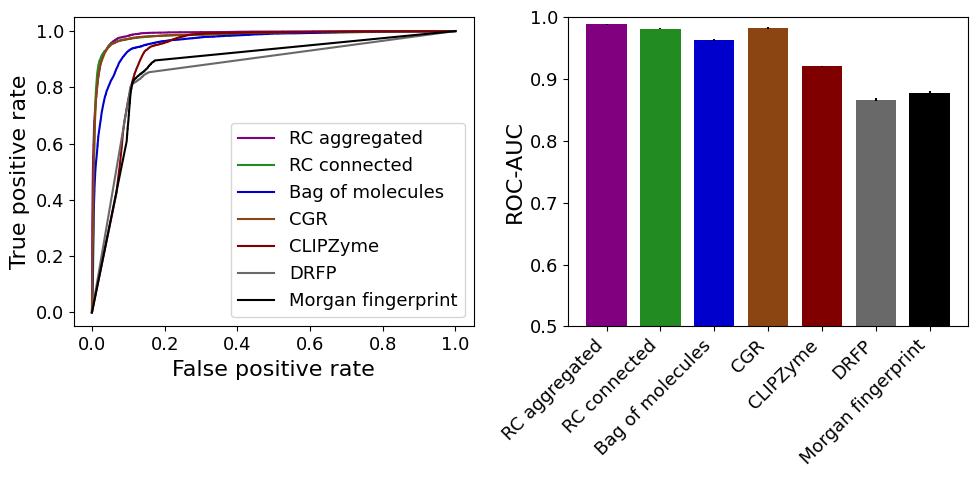

Random reaction center - Negative multiple 1


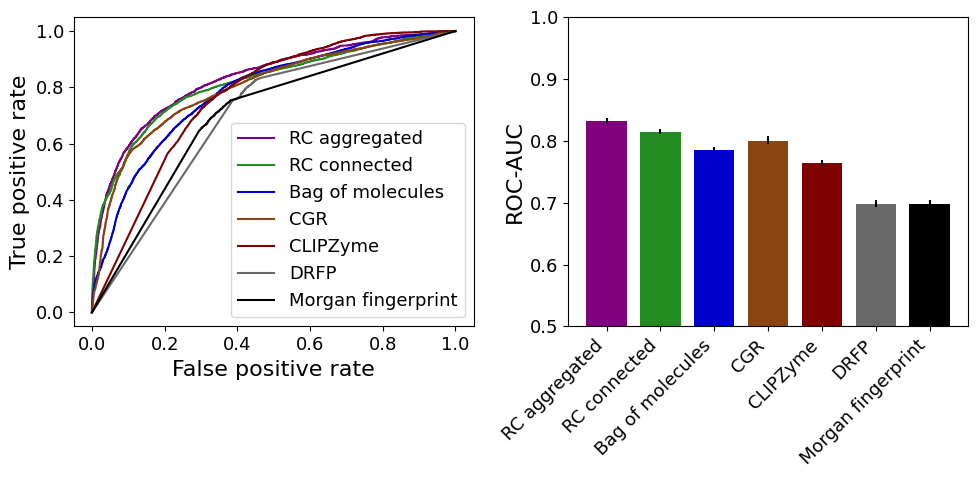

Random reaction center - Negative multiple 3


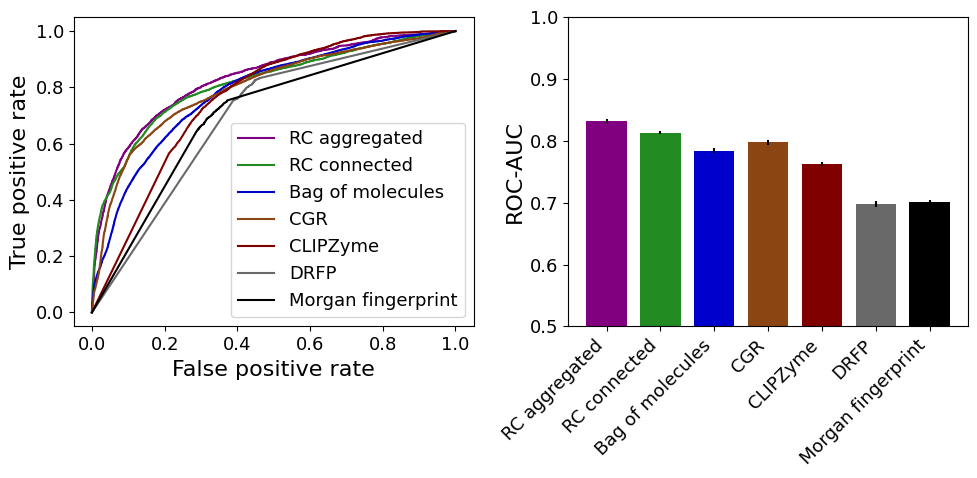

Random reaction center - Negative multiple 5


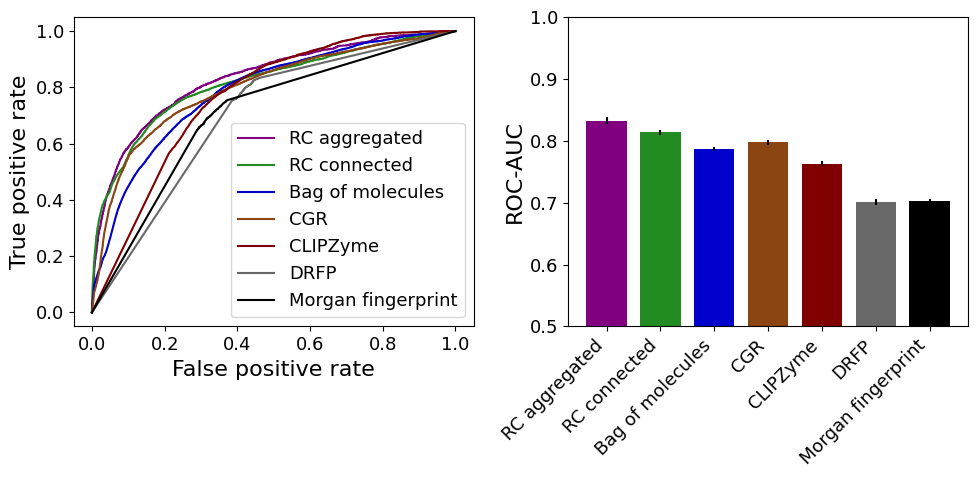

Random reaction center - Negative multiple 10


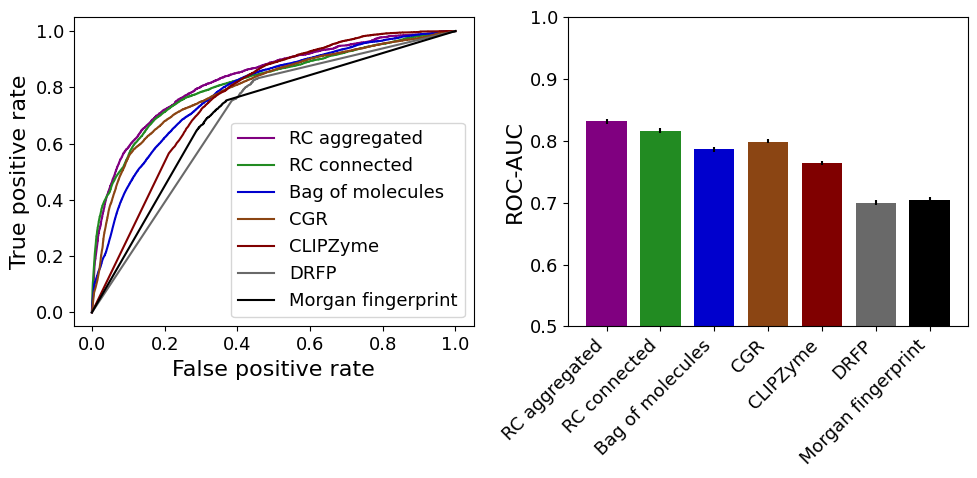

RCMCS - Negative multiple 1


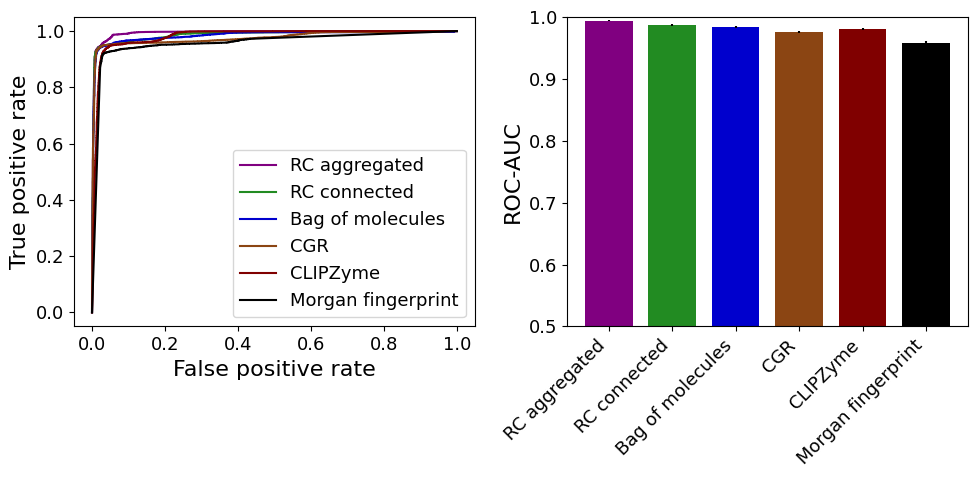

RCMCS - Negative multiple 3


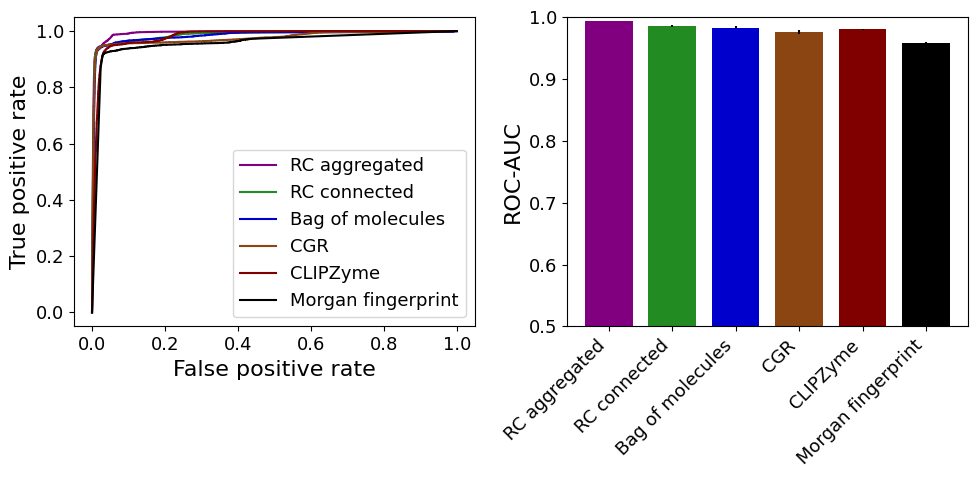

RCMCS - Negative multiple 5


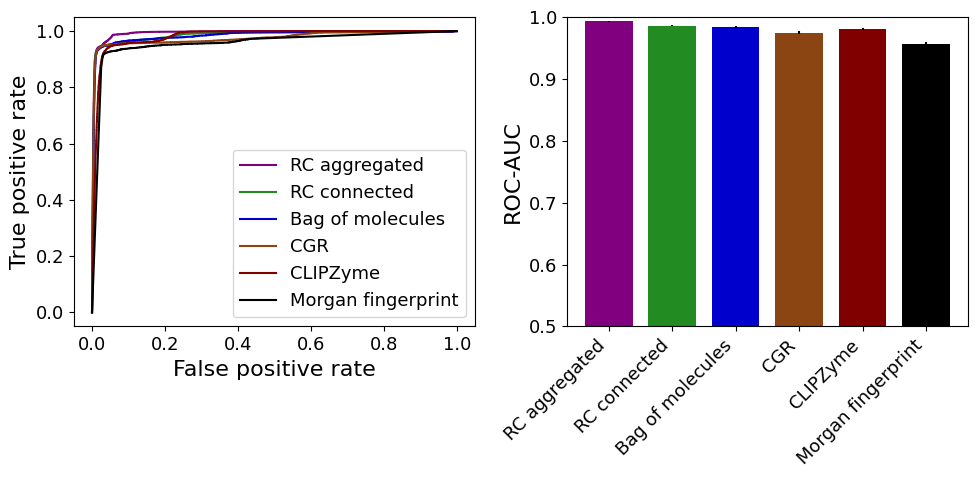

RCMCS - Negative multiple 10


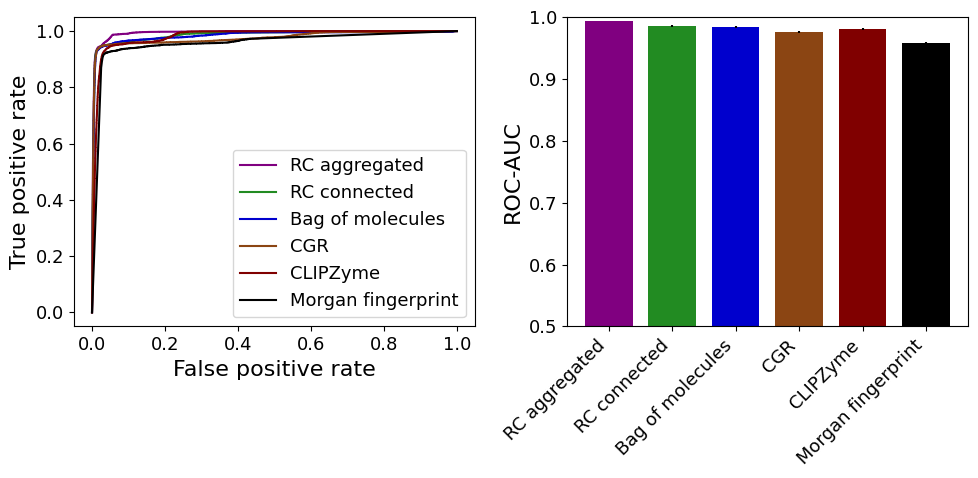

In [62]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    roc_fig, roc_axs = plt.subplots(ncols=2, figsize=figsize)
    for _, row in df.drop_duplicates(['id', 'model']).sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        pred = preds[id].loc[nm_keep_indices[id][nm]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        auroc_u, auroc_cil, auroc_ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == 'roc_auc'),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        roc_axs[0].plot(fpr, tpr, color=colors[model_name], label=labels[model_name])

        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        roc_axs[1].bar(labels[model_name], height=auroc_u, width=width, yerr=ci, color=colors[model_name])
        
        roc_axs[1].set_ylabel("ROC-AUC")
        roc_axs[1].set_ylim(ylim)
        for label in roc_axs[1].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)
    
    roc_axs[0].set_xlabel("False positive rate")
    roc_axs[0].set_ylabel("True positive rate")
    roc_axs[0].legend()
    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.show()

Top models inner val metrics with test overlay

In [90]:
# Bar chart constants

figsize = (15, 5)
width = 0.75  # the width of the bars
xtick_rot = 60
xtick_ha = 'right'
scl_chance = 0.9
chance_color = 'orange'

In [95]:
chance

{('rcmcs', 1, 'f1'): np.float64(0.5022449593031298),
 ('rcmcs', 1, 'binary_precision'): np.float64(0.5002351202205024),
 ('rcmcs', 1, 'binary_recall'): np.float64(0.49406341637950224),
 ('rcmcs', 1, 'accuracy'): np.float64(0.5053675964187327),
 ('rcmcs', 3, 'f1'): np.float64(0.3279664431061513),
 ('rcmcs', 3, 'binary_precision'): np.float64(0.2496149834153246),
 ('rcmcs', 3, 'binary_recall'): np.float64(0.5118980503157041),
 ('rcmcs', 3, 'accuracy'): np.float64(0.49609590220385674),
 ('rcmcs', 5, 'f1'): np.float64(0.2507230960056867),
 ('rcmcs', 5, 'binary_precision'): np.float64(0.16700493582216536),
 ('rcmcs', 5, 'binary_recall'): np.float64(0.498203156937674),
 ('rcmcs', 5, 'accuracy'): np.float64(0.4991649449035814),
 ('rcmcs', 10, 'f1'): np.float64(0.1712006620874027),
 ('rcmcs', 10, 'binary_precision'): np.float64(0.10248371061561745),
 ('rcmcs', 10, 'binary_recall'): np.float64(0.5008603470302997),
 ('rcmcs', 10, 'accuracy'): np.float64(0.5001017897289739),
 ('homology', 1, 'f1'

In [98]:
chance[('drfp', 3, 'f1')]

np.float64(0.33110979103373017)

DRFP - Negative multiple 1


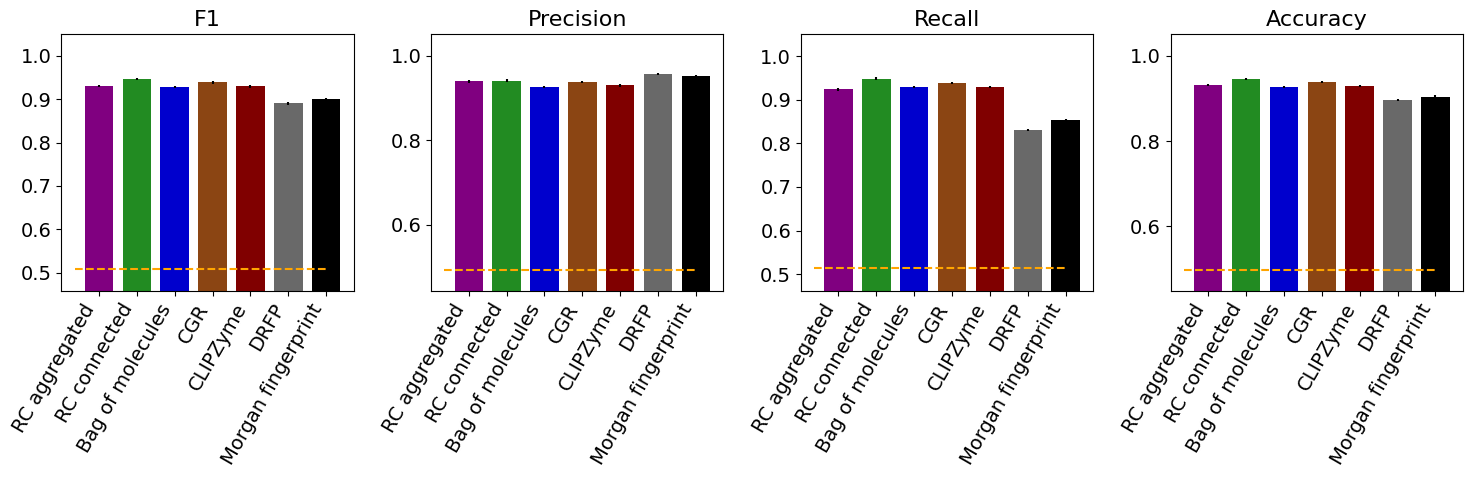

DRFP - Negative multiple 3


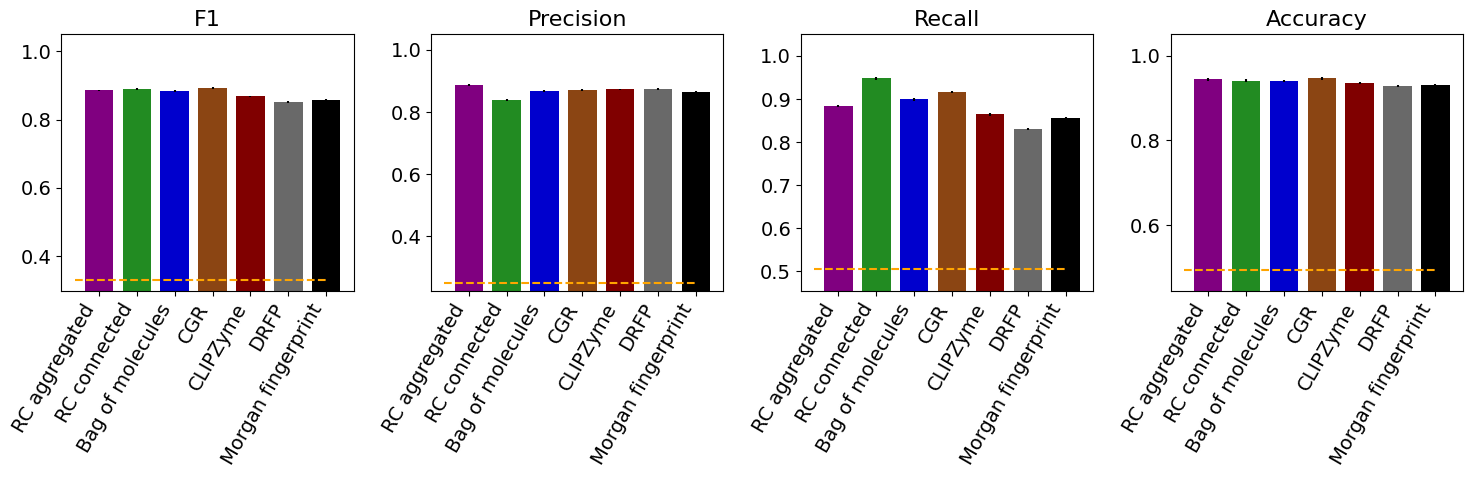

DRFP - Negative multiple 5


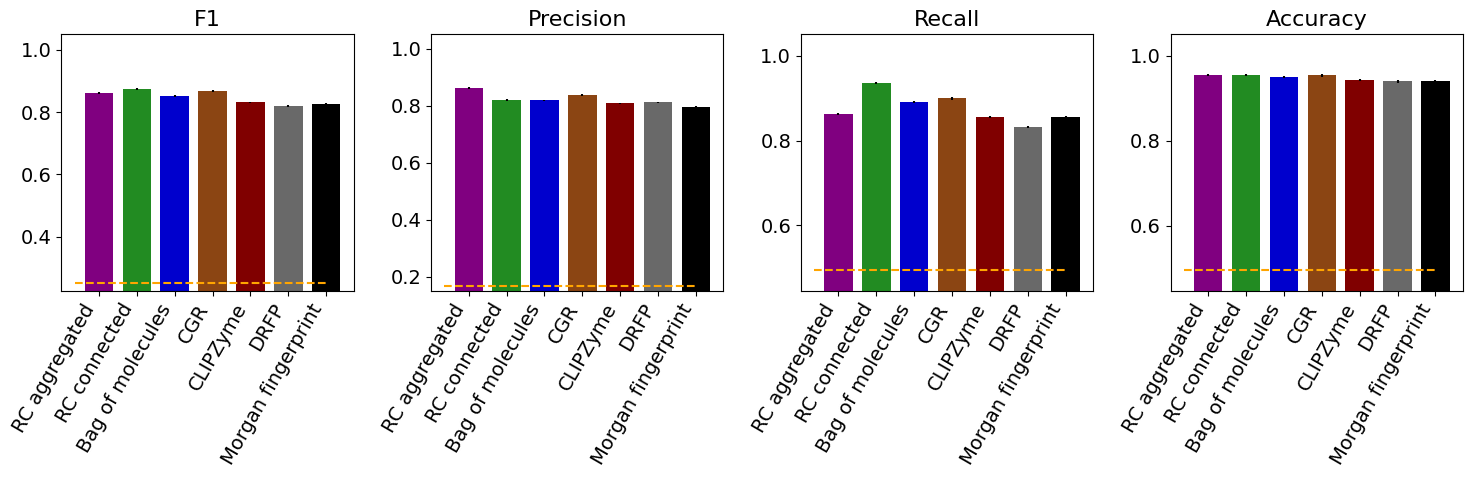

DRFP - Negative multiple 10


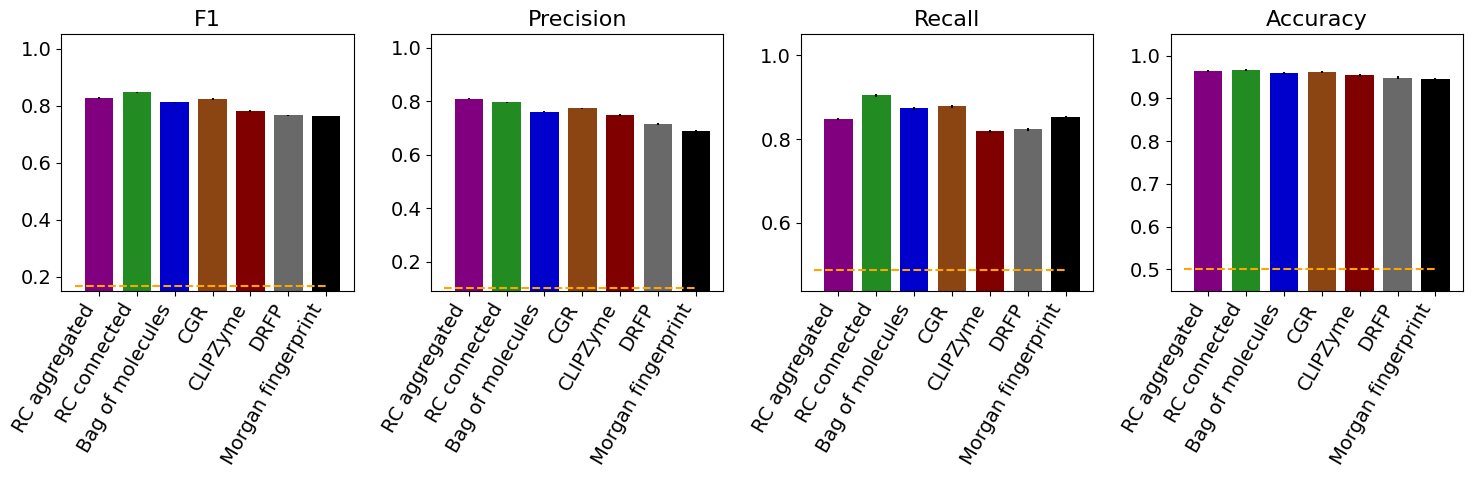

ESM - Negative multiple 1


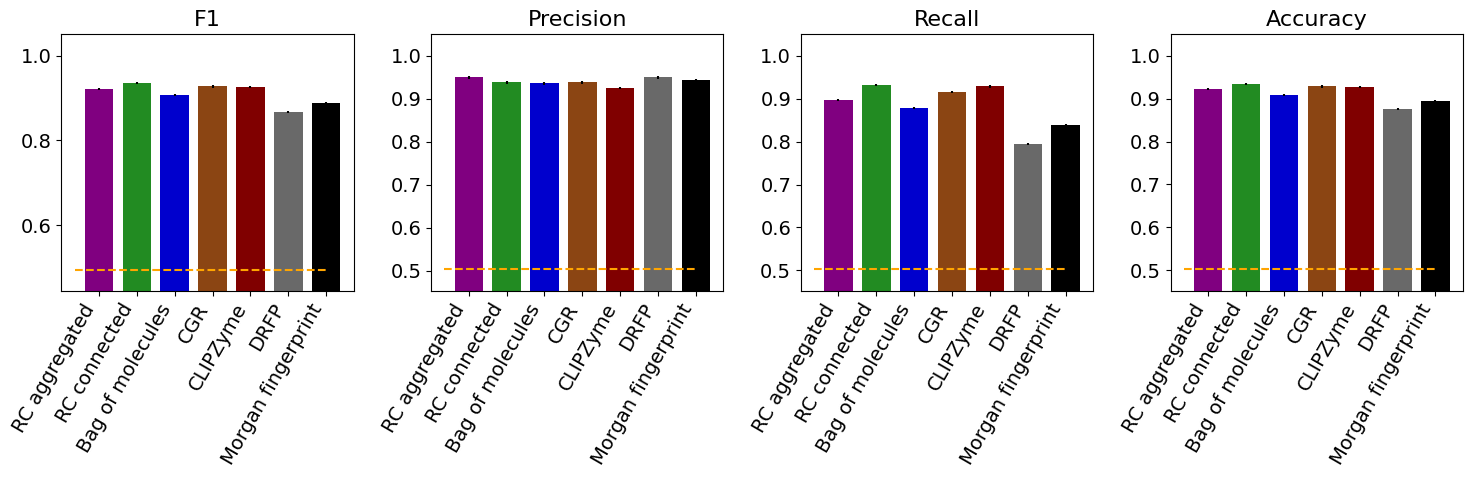

ESM - Negative multiple 3


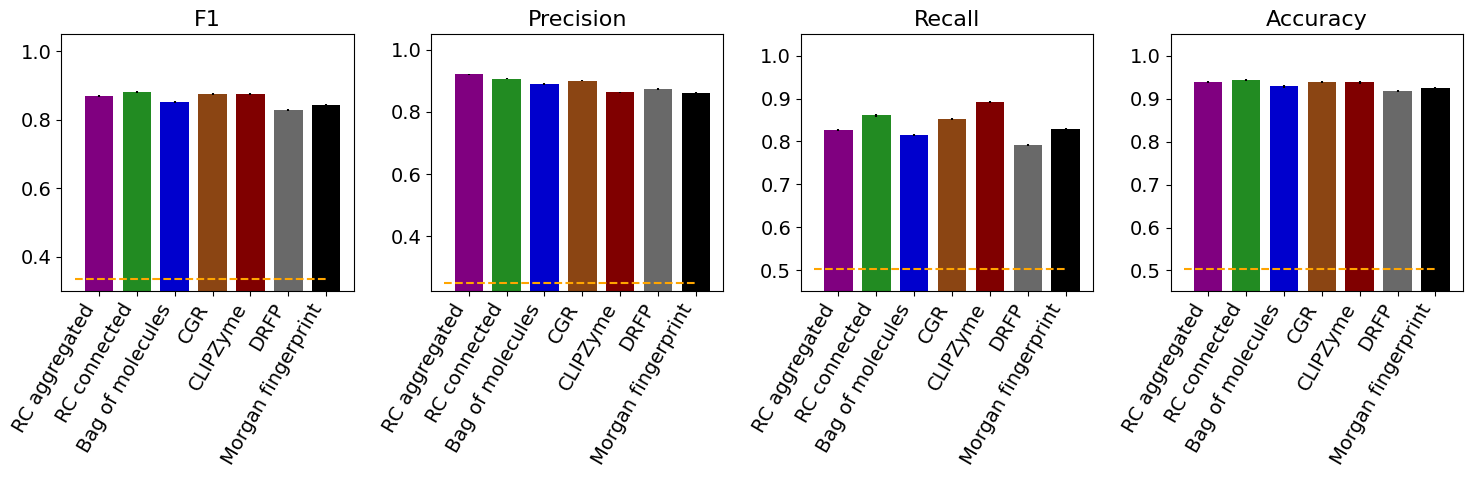

ESM - Negative multiple 5


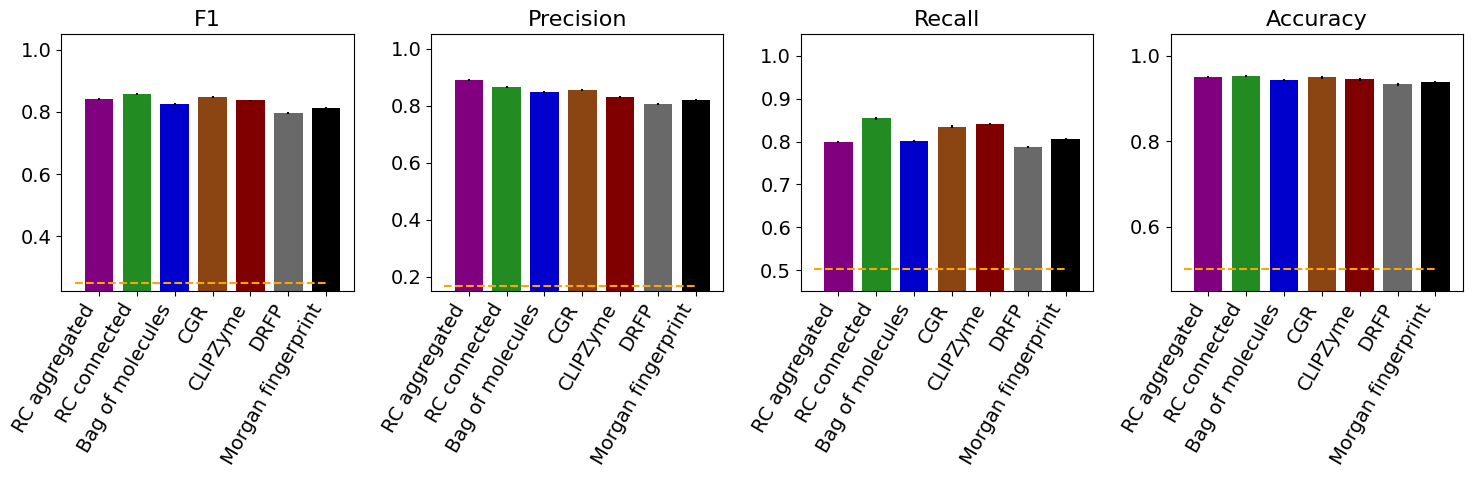

ESM - Negative multiple 10


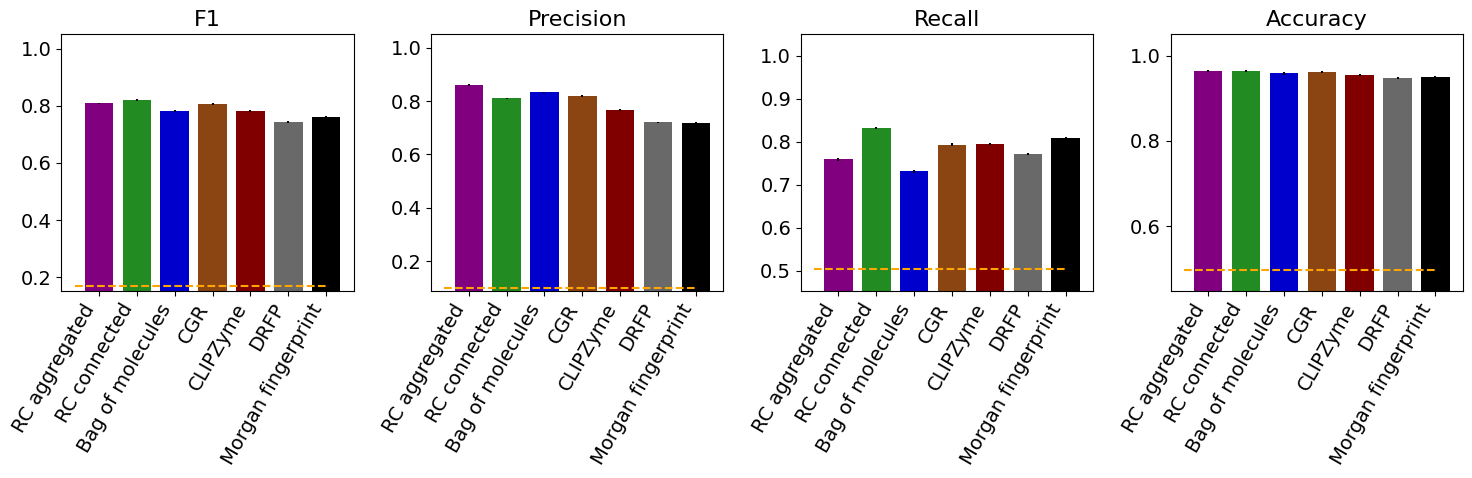

GSI - Negative multiple 1


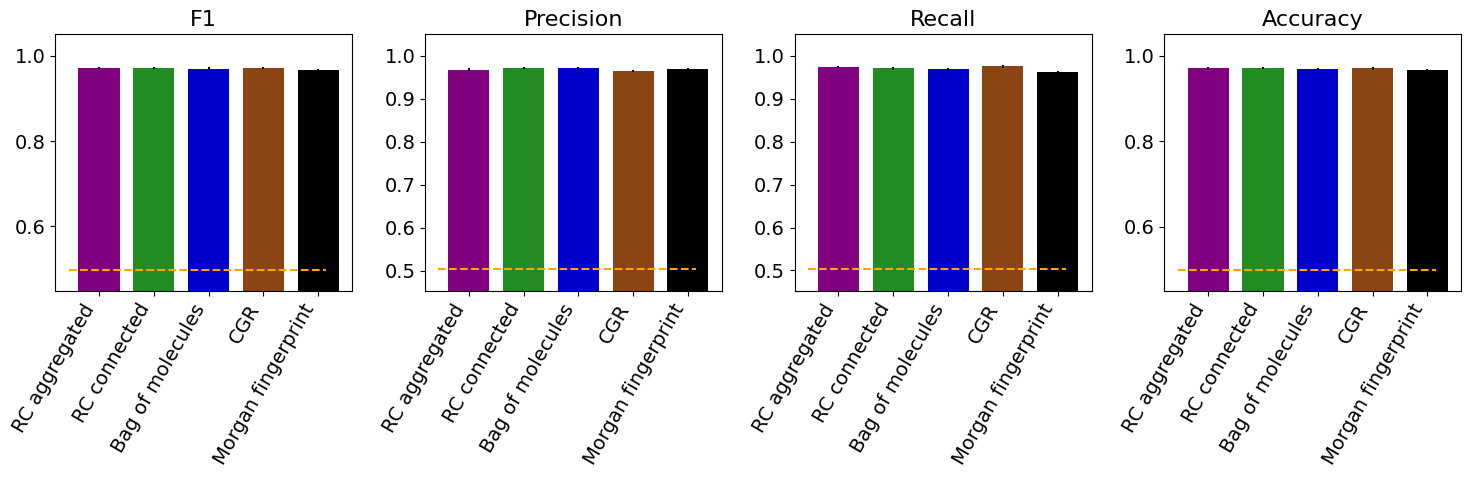

GSI - Negative multiple 3


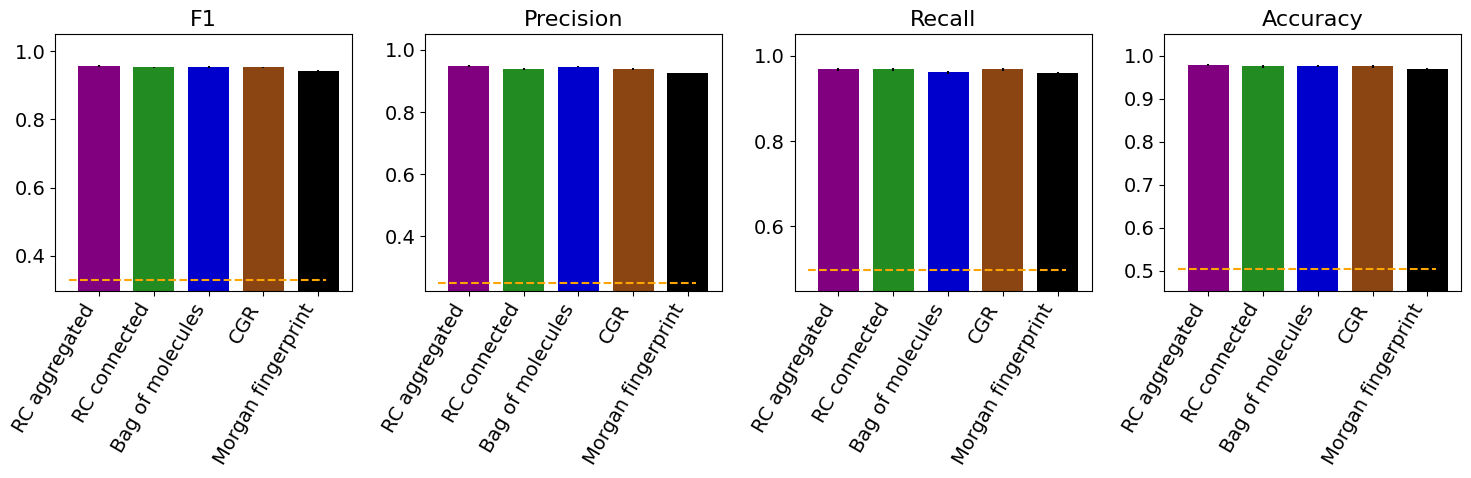

GSI - Negative multiple 5


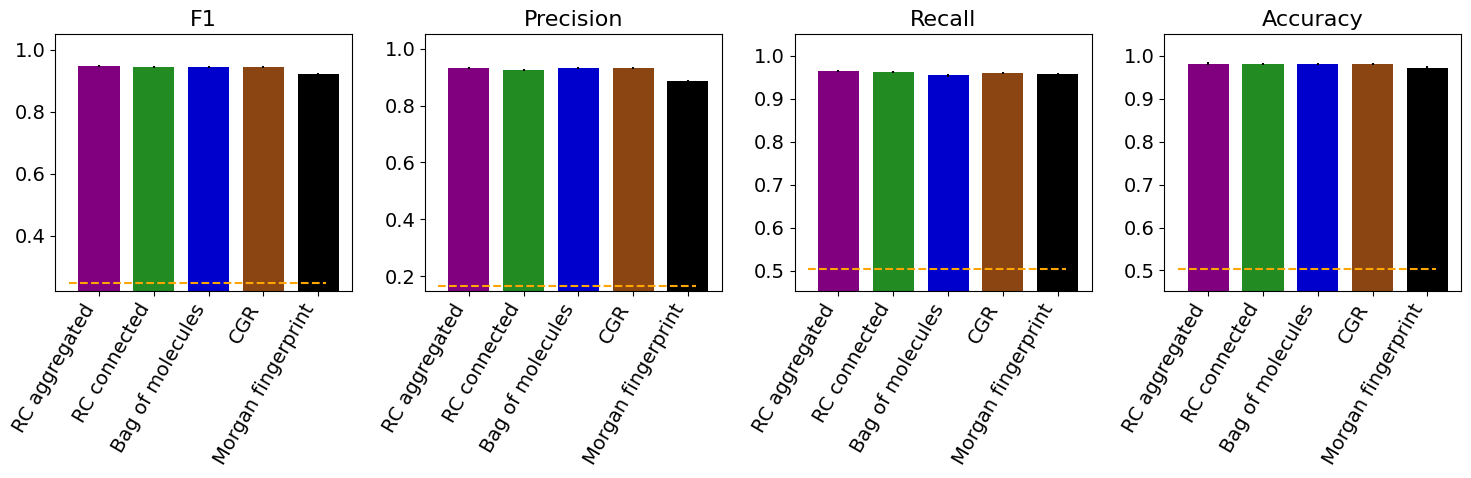

GSI - Negative multiple 10


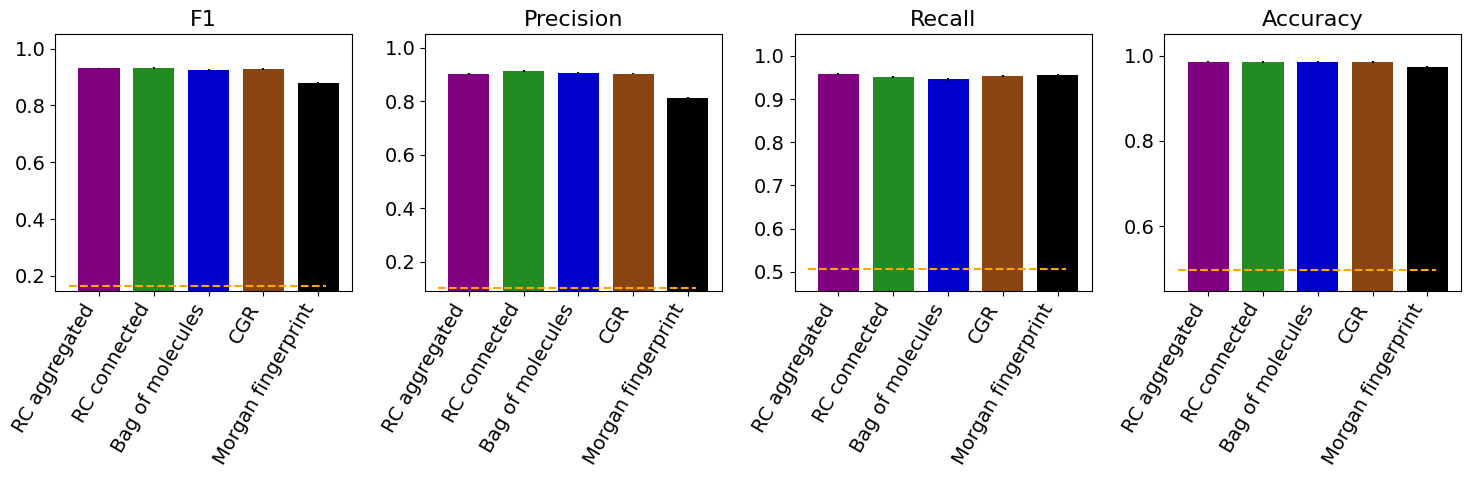

Random reaction - Negative multiple 1


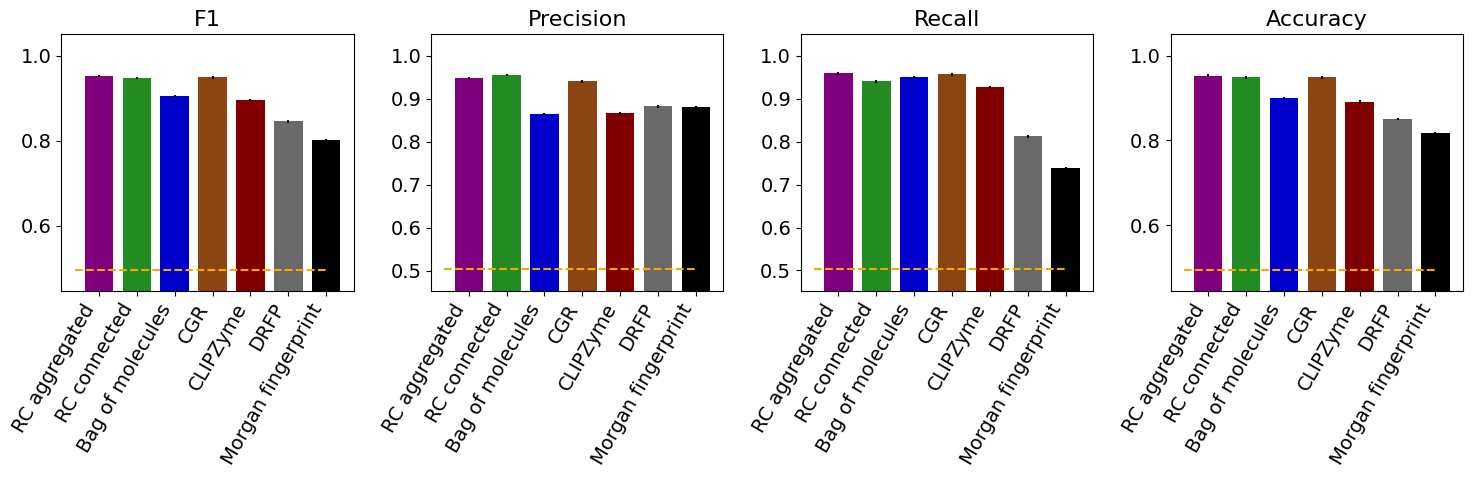

Random reaction - Negative multiple 3


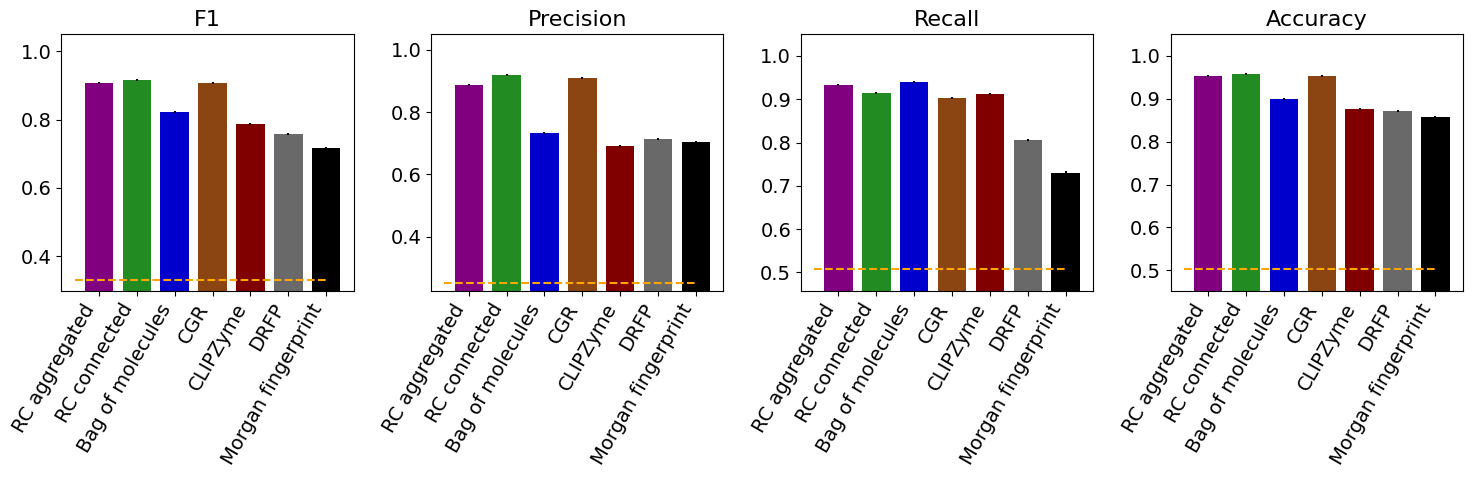

Random reaction - Negative multiple 5


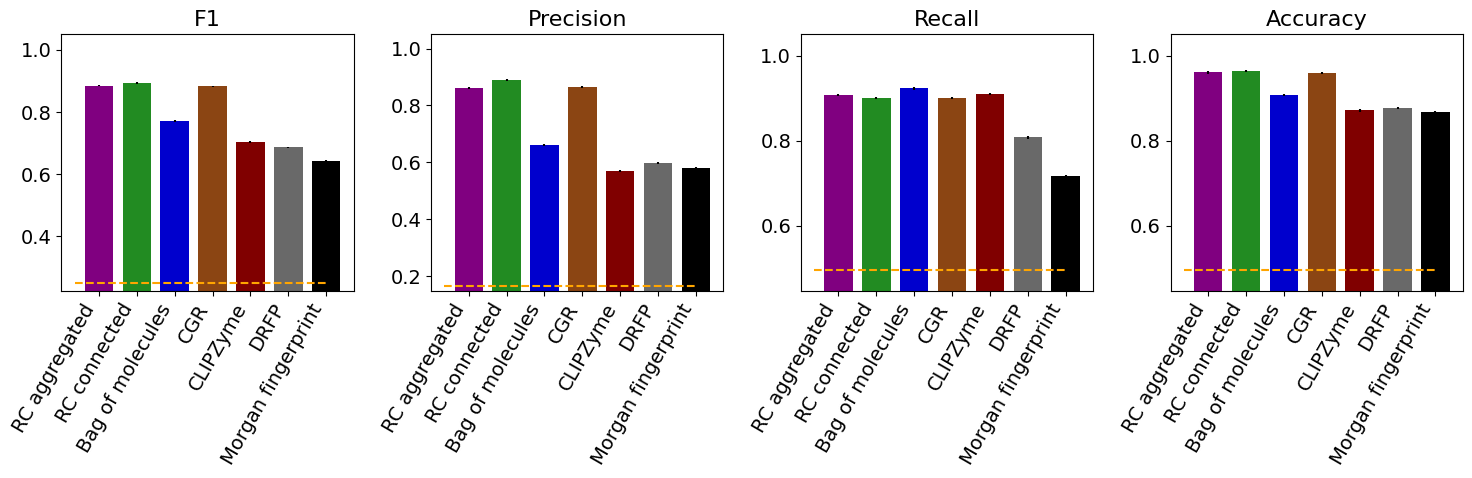

Random reaction - Negative multiple 10


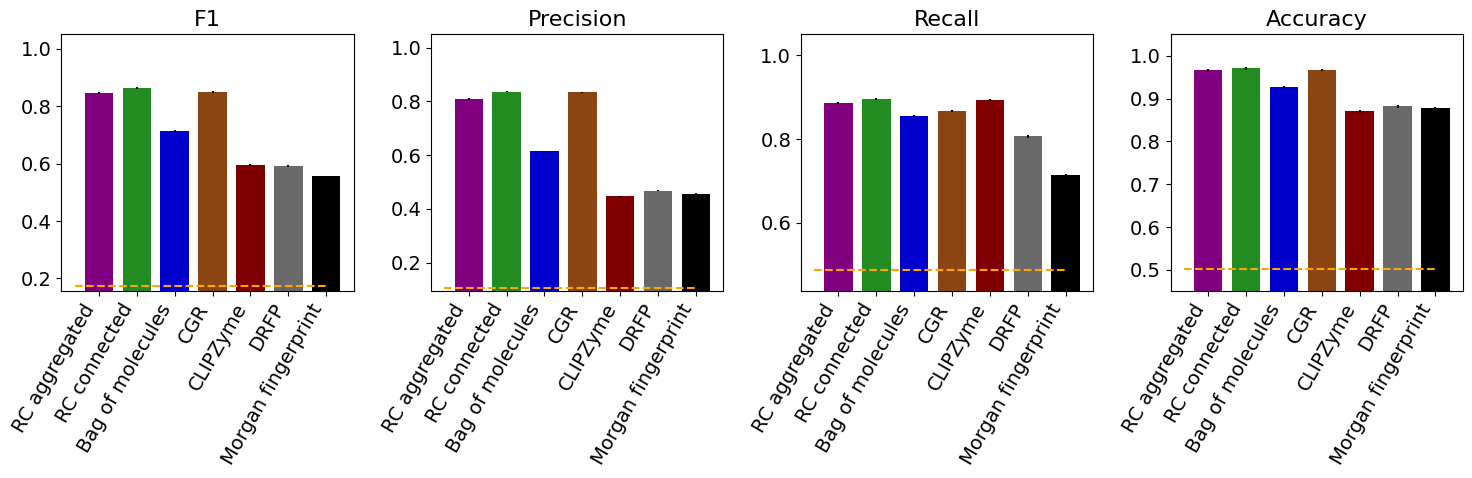

Random reaction center - Negative multiple 1


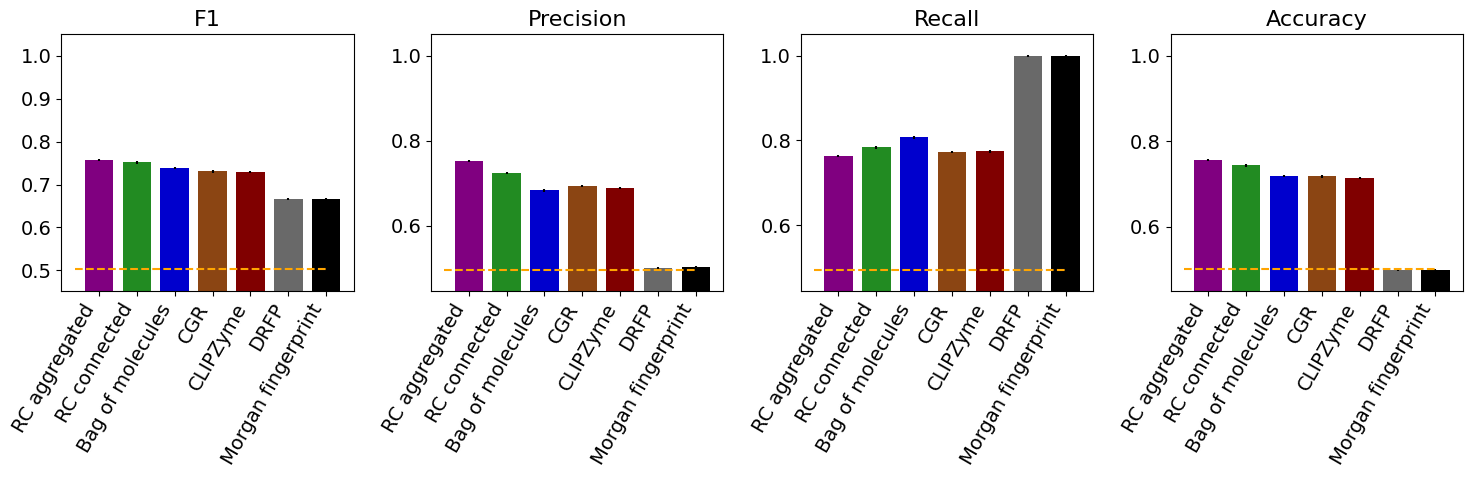

Random reaction center - Negative multiple 3


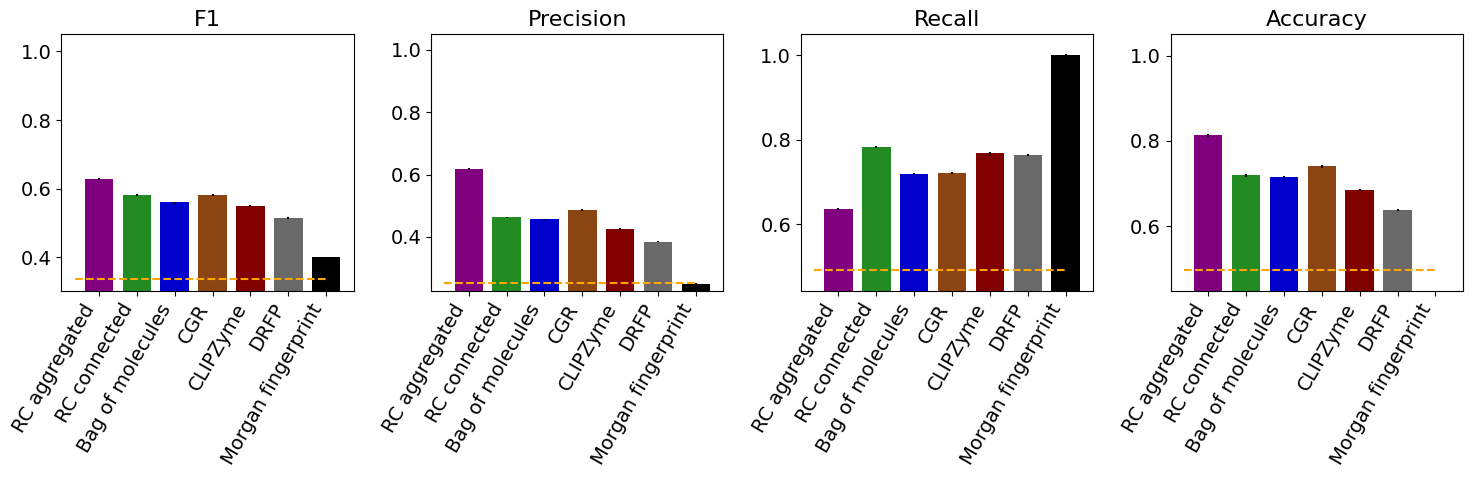

Random reaction center - Negative multiple 5


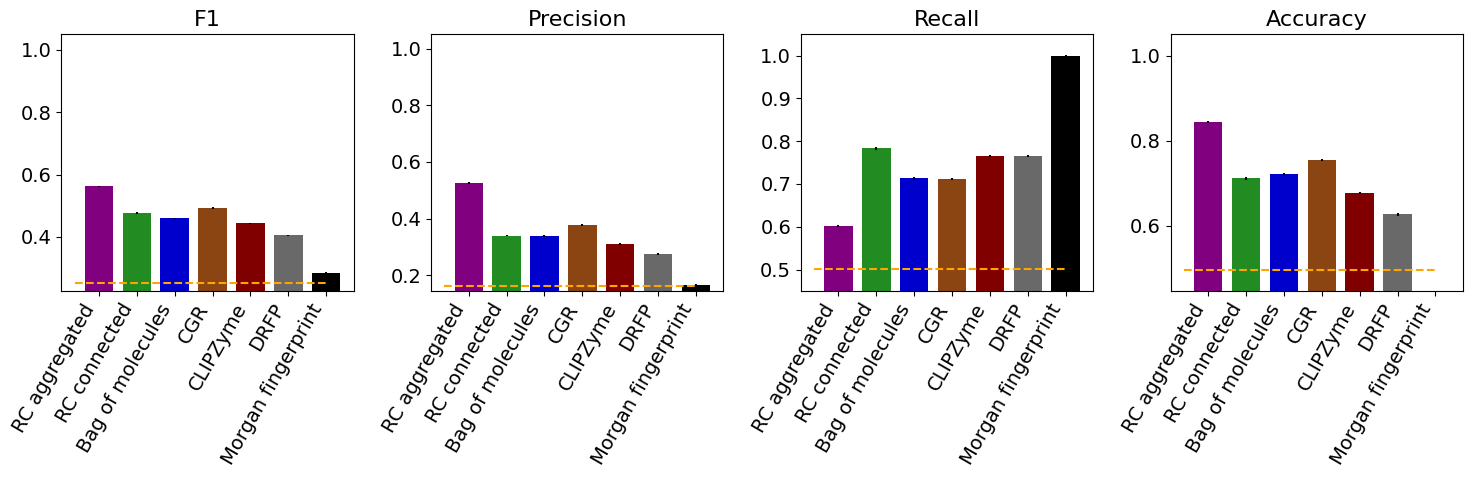

Random reaction center - Negative multiple 10


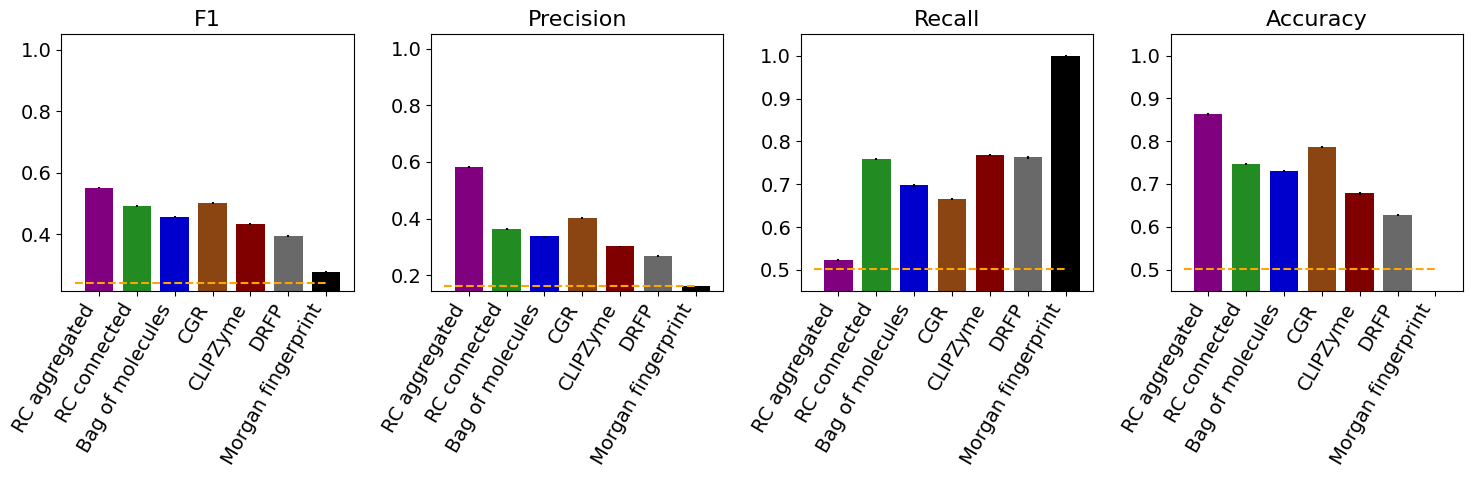

RCMCS - Negative multiple 1


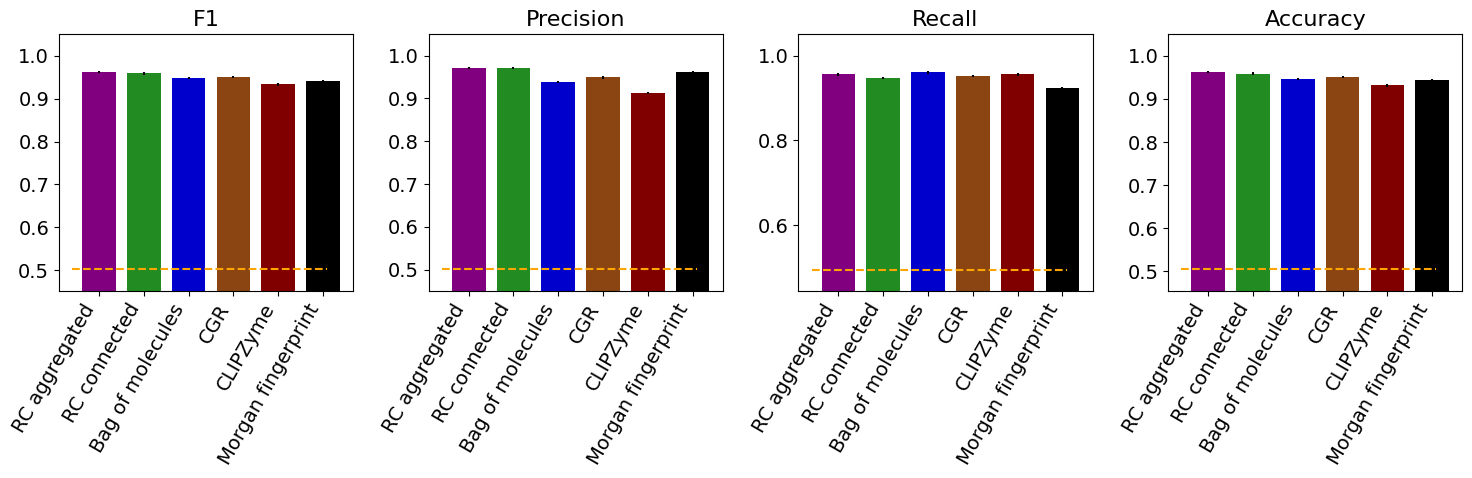

RCMCS - Negative multiple 3


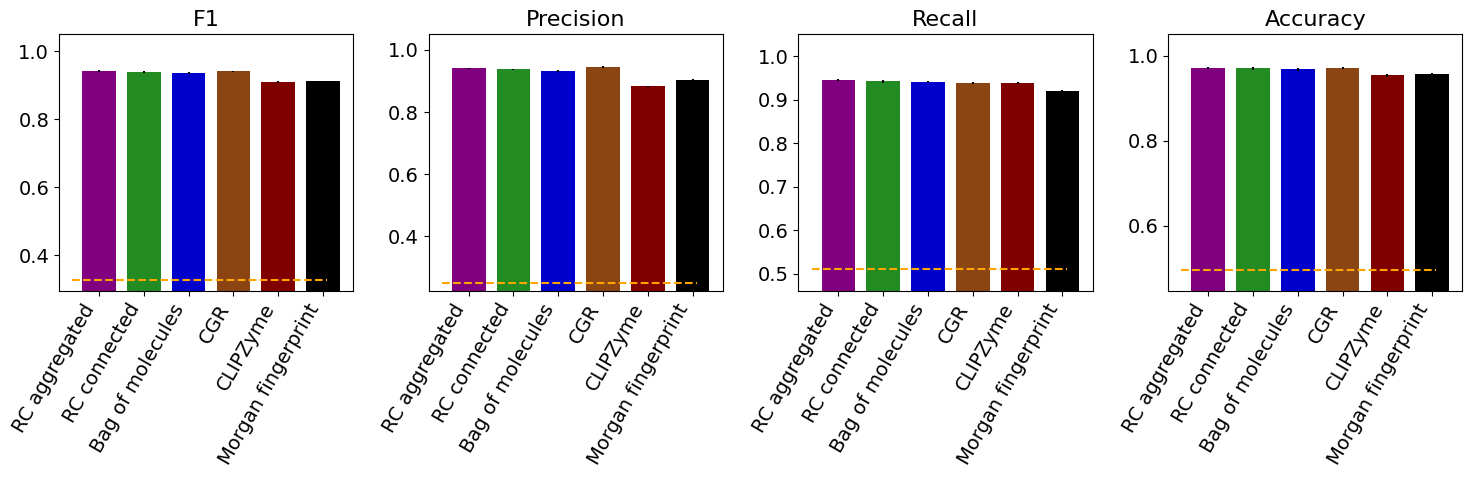

RCMCS - Negative multiple 5


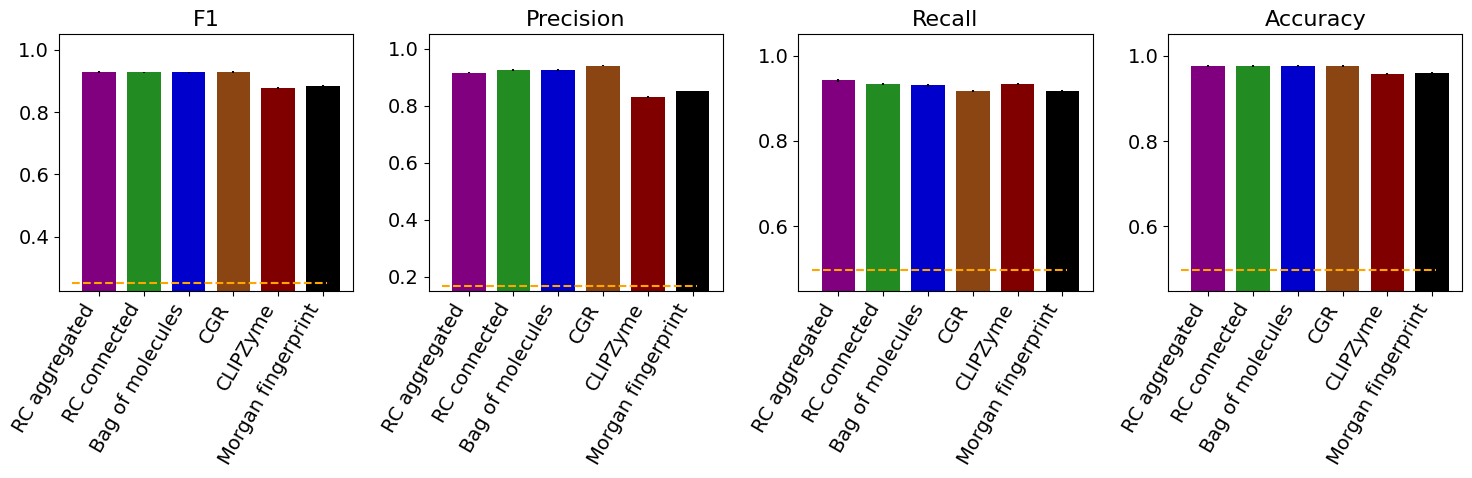

RCMCS - Negative multiple 10


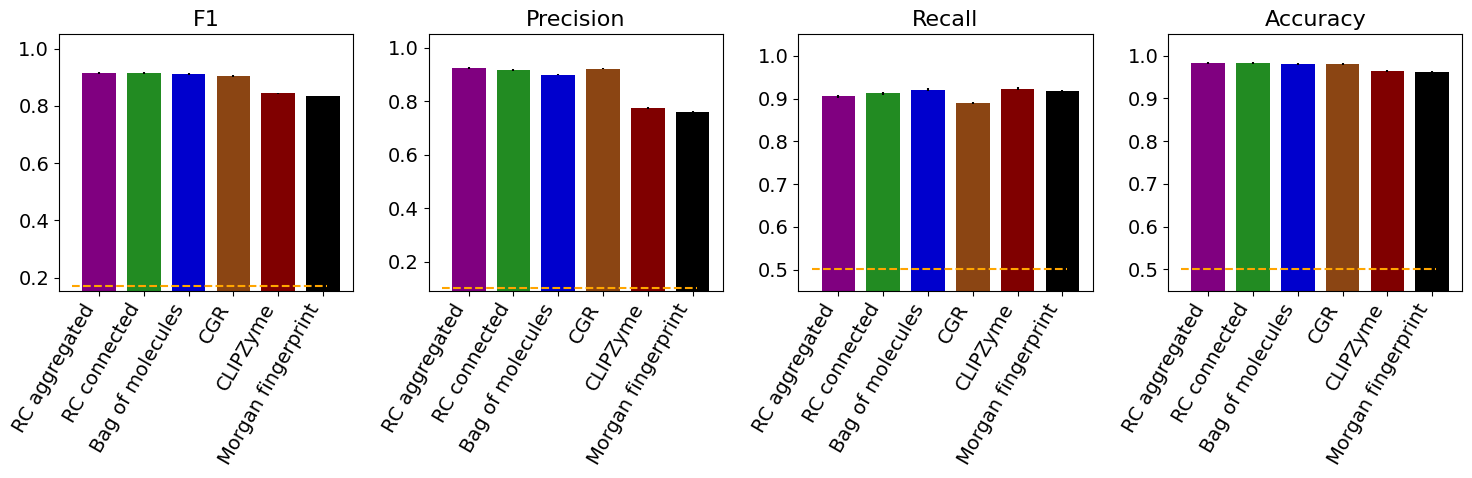

In [ ]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=False)
    for _, row in df.sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        metric_k = row['metric']
        if metric_k not in metrics:
            continue
        i = list(metrics.keys()).index(metric_k)
        
        u, cil, ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == metric_k),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        ax[i].bar(labels[model_name], height=u, width=width, yerr=ci, color=colors[model_name])
        

        for label in ax[i].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)

    for i in range(len(ax)):
        metric_k = list(metrics.keys())[i]
        ax[i].set_title(metric_names[metric_k])
        _chance = chance[(strat, nm, metric_k)]
        ax[i].set_ylim(scl_chance * _chance, 1.05)
        # Plot horizontal line at chance from min to max x
        x_min, x_max = [0.95 * elt for elt in ax[i].get_xlim()]
        ax[i].hlines(y=_chance, xmin=x_min, xmax=x_max, color=chance_color, linestyle='--')


    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.show()        

Performance broken down by similarity bucket

In [103]:
id2name

{'ff90895a6070499b8fdcdc0982526885': {'data': 'rcmcs', 'model': 'bom'},
 '8a155bc5673b4c6aa8667dd55755fe0b': {'data': 'rcmcs', 'model': 'rc_agg'},
 '5ca6ba7b8aec4b81a366e9138b9c09b0': {'data': 'rcmcs', 'model': 'rc_cxn'},
 '2241478505f9497885d25b9a0dee3ffd': {'data': 'homology', 'model': 'rc_cxn'},
 'e638683b53f84d0ba1c8f32794413e0e': {'data': 'homology', 'model': 'rc_agg'},
 'fb3c7a9061a744fba7dabf9d50092414': {'data': 'rcmcs', 'model': 'mfp'},
 '4bf93c6830744a4b8e6d8076f14a82e1': {'data': 'homology', 'model': 'mfp'},
 'ef2ce94281fb445ba304791f991e23cc': {'data': 'homology', 'model': 'bom'},
 '3c1ce655b064442cb7789fa210e4caaf': {'data': 'homology', 'model': 'cgr'},
 '2a7b803f790143f0b14a1955117cb393': {'data': 'rcmcs', 'model': 'cgr'},
 'ac4018e22f994c26921bc3a3a0797d58': {'data': 'random_reaction',
  'model': 'mfp'},
 'b036364095f945ebb7b326e8376167b9': {'data': 'random_reaction',
  'model': 'drfp'},
 'e35758e78f444ffcb352891483f11dcd': {'data': 'random_reaction',
  'model': 'bom'},


In [104]:
sim_path = Path(filepaths.results) / 'similarity_matrices'
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
similarity_metrics = [
    'rcmcs',
    'homology',
    'drfp',
    'esm',
]

for sim in similarity_metrics:
    print("Doing sim analysis for", sim)
    eg = top_models.loc[top_models['data/split_strategy'] == sim, 'Run ID'].iloc[0]

    S = load_similarity_matrix(
        sim_path=sim_path,
        dataset=dataset,
        toc=toc,
        sim_metric=sim if sim != 'homology' else 'gsi'
    )
    
    if sim in ['rcmcs', 'drfp']:
        val_idx = preds[eg].loc[:, 'reaction_idx'].to_list()
    elif sim in ['homology', 'esm']:
        val_idx = preds[eg].loc[:, 'protein_idx'].to_list()

    train_idx = [i for i in range(S.shape[0]) if i not in val_idx]
    max_sims = S[:, val_idx][train_idx].max(axis=0)

    for id in preds.keys():
        if id2name[id]['data'] == sim:
            preds[id]['max_sim'] = max_sims

del S

Doing sim analysis for rcmcs
Doing sim analysis for homology


: 

In [ ]:
# Clustered bar chart constants

bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ],
    'drfp': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'esm': [
        (0.98, 1),
        (0.97, 0.98),
        (0.95, 0.97),
        (0.0, 0.95),
    ]

}

bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.17
space = 1.03
offset = (len(labels) / 2) * width
figsize = (11, 4)
ylim = {
    'rcmcs': (0.2, 1.0),
    'homology': (0.6, 1.0),
} 

rcmcs
f1
bom 0.9401378134009826
rc_agg 0.9460002292501134
rc_cxn 0.9504582703755378
mfp 0.9135493897322617
cgr 0.940294441263495
bom 0.9214195294419266
rc_agg 0.9268948967739021
rc_cxn 0.9262488732819745
mfp 0.8675429868731169
cgr 0.9290357479231902
bom 0.793593263901149
rc_agg 0.845665704868782
rc_cxn 0.8298984810479593
mfp 0.8239143313657173
cgr 0.7824737740635679
bom 0.662867120862882
rc_agg 0.7810153996611742
rc_cxn 0.6275802407893756
mfp 0.3317390628917382
cgr 0.5542996711420022


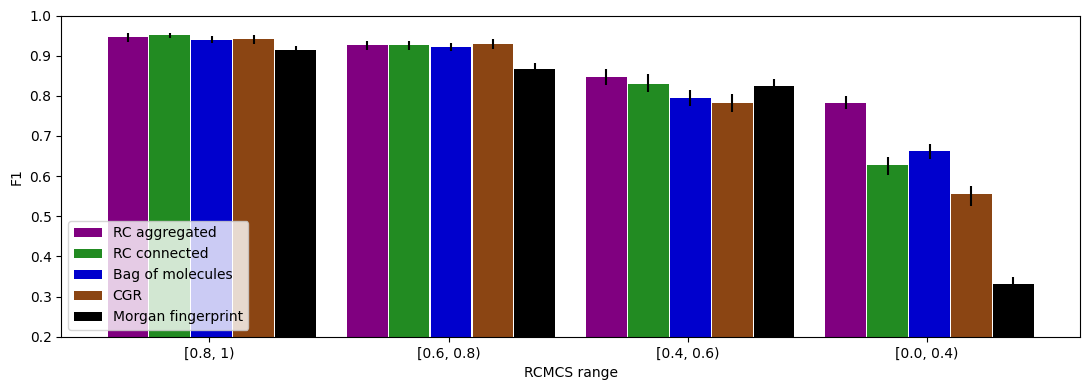

binary_precision
bom 0.9149237939621315
rc_agg 0.946396769334246
rc_cxn 0.9474377706688207
mfp 0.9603066942267303
cgr 0.9299145623122133
bom 0.915453385974434
rc_agg 0.9360529360352197
rc_cxn 0.9388902591129366
mfp 0.9477926889800418
cgr 0.9317888809052342
bom 0.8980020971158664
rc_agg 0.9213376829376654
rc_cxn 0.9143715006195724
mfp 0.9392703757135729
cgr 0.9006100486289143
bom 0.9149916220262158
rc_agg 0.9380444107999906
rc_cxn 0.9135875722922564
mfp 0.91822964470226
cgr 0.8901048388631707


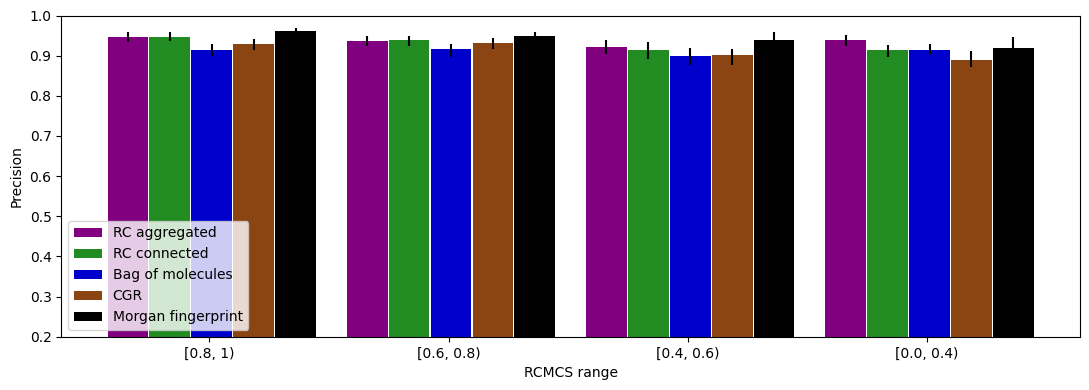

binary_recall
bom 0.9678296232960268
rc_agg 0.9424561872541085
rc_cxn 0.9526521272099212
mfp 0.8723077983254531
cgr 0.9516909447615111
bom 0.9269607555044814
rc_agg 0.9237916757102854
rc_cxn 0.9145086321141401
mfp 0.7991279726633935
cgr 0.925146169738857
bom 0.7069145906515982
rc_agg 0.7889546697974525
rc_cxn 0.7560746092522558
mfp 0.7303739865729336
cgr 0.6965397675428848
bom 0.5162530752055158
rc_agg 0.6690715059848782
rc_cxn 0.4783856744886106
mfp 0.20300676243796134
cgr 0.4022982536283677


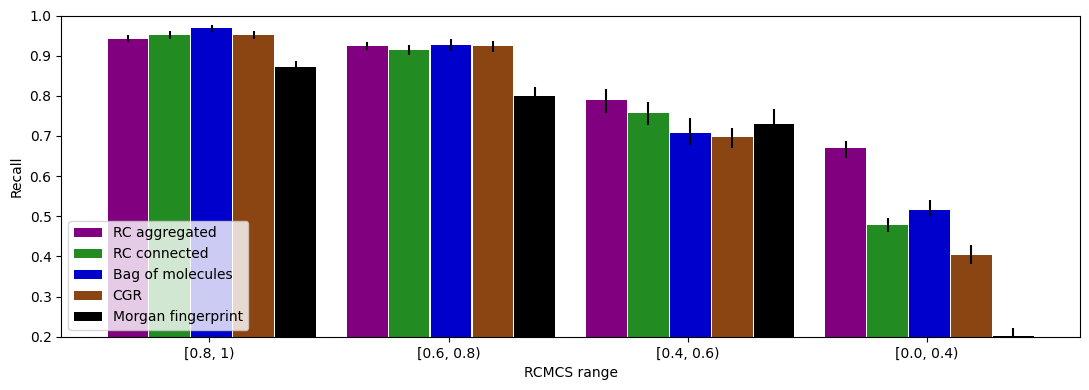

accuracy
bom 0.9472884168602722
rc_agg 0.9540192499170261
rc_cxn 0.9569731164951876
mfp 0.9304414205111187
cgr 0.9509790906073681
bom 0.9285214747244395
rc_agg 0.9374762447738502
rc_cxn 0.9352945648042568
mfp 0.89096921322691
cgr 0.9379095400988217
bom 0.8344291691572026
rc_agg 0.8736640765092646
rc_cxn 0.8649611476389718
mfp 0.860011954572624
cgr 0.8294321578003587
bom 0.6886825817860301
rc_agg 0.7798290598290598
rc_cxn 0.6663129973474803
mfp 0.518821102269378
cgr 0.6206130268199235


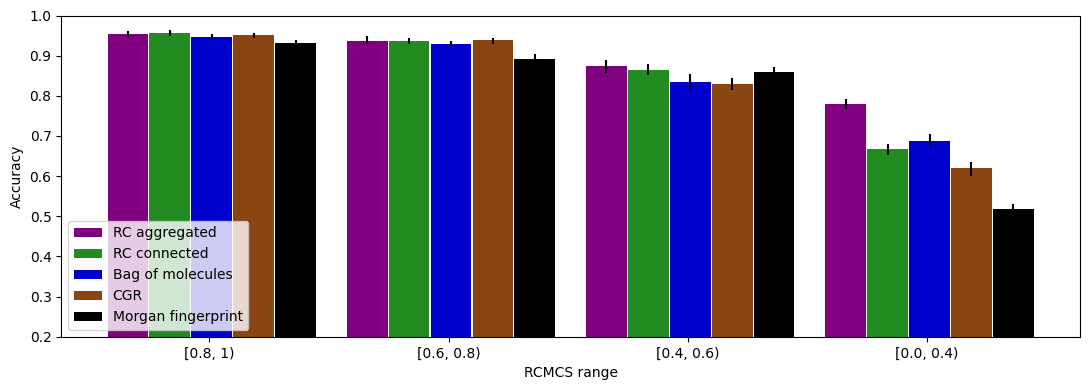

homology
f1
rc_cxn 0.9882639943793271
rc_agg 0.9872664370327443
mfp 0.9840658369518462
bom 0.9894731677745331
cgr 0.9913889258180701
rc_cxn 0.9715854748045794
rc_agg 0.9647297558902385
mfp 0.9567216721994921
bom 0.9693439282024282
cgr 0.9711314408873574
rc_cxn 0.9396150541460812
rc_agg 0.9404009227750393
mfp 0.9233005778010527
bom 0.9326728719264247
cgr 0.943047915819274
rc_cxn 0.9474772638945064
rc_agg 0.9479372305052243
mfp 0.93573180705437
bom 0.9418073749859103
cgr 0.9470416899712275


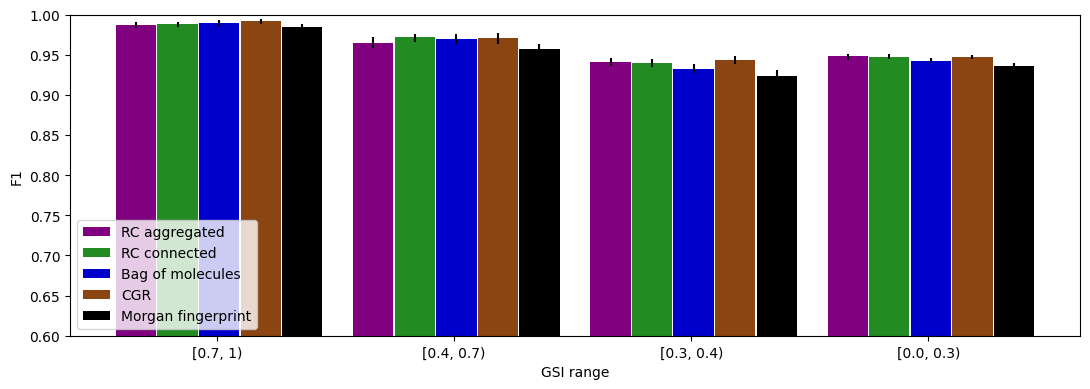

binary_precision
rc_cxn 0.9778208419327266
rc_agg 0.9747856903741983
mfp 0.9734092585227608
bom 0.9804113625383728
cgr 0.9830087685063595
rc_cxn 0.97387975270909
rc_agg 0.9667729366814699
mfp 0.9585758505514357
bom 0.974386470781655
cgr 0.9765308425098844
rc_cxn 0.9595188511245466
rc_agg 0.95273623652307
mfp 0.9480789236822337
bom 0.956646001176251
cgr 0.9601864895370068
rc_cxn 0.9736497836325665
rc_agg 0.9658530191917005
mfp 0.9662625018318274
bom 0.9710944545611203
cgr 0.9745153282609652


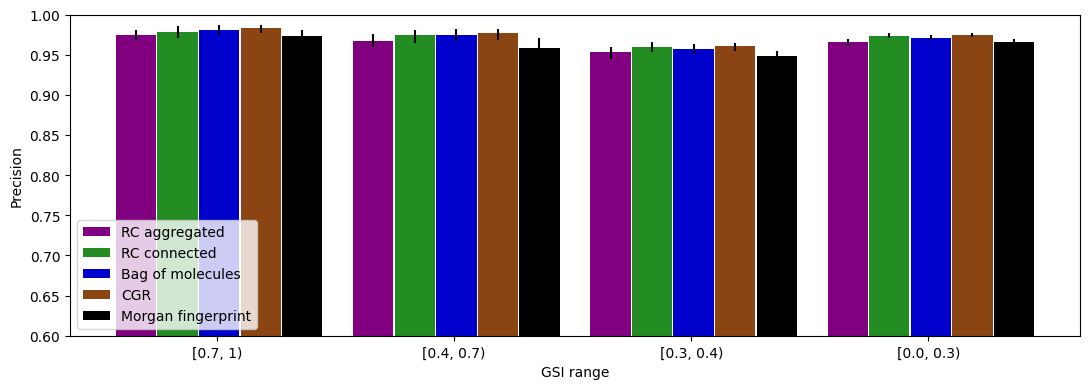

binary_recall
rc_cxn 0.9993083349478242
rc_agg 1.0
mfp 0.9946075856768049
bom 0.9993503030416617
cgr 1.0
rc_cxn 0.9678199177506811
rc_agg 0.9652669315595781
mfp 0.9538143341910441
bom 0.9646271132736102
cgr 0.9673616073190793
rc_cxn 0.921910492751898
rc_agg 0.9266111871551073
mfp 0.8965996643233097
bom 0.9098997843154385
cgr 0.927651918726432
rc_cxn 0.9225067894591257
rc_agg 0.9306328336351369
mfp 0.9063344779941674
bom 0.9133090517473434
cgr 0.9206295001951222


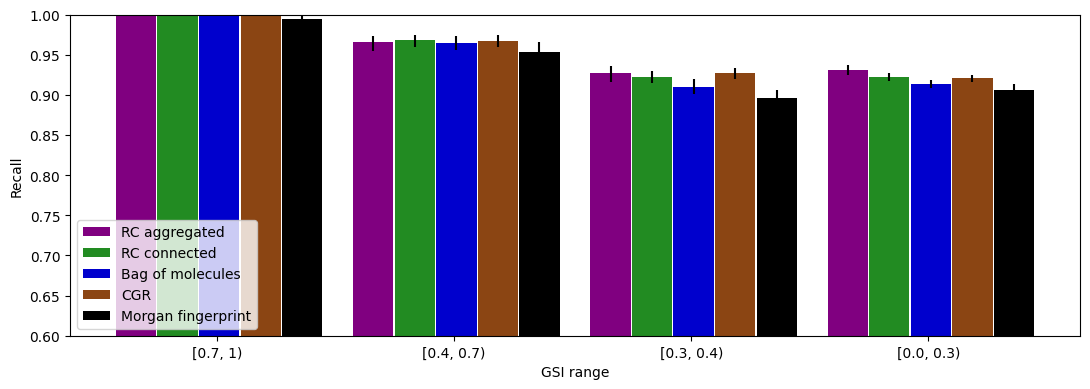

accuracy
rc_cxn 0.9864678404599354
rc_agg 0.9856701401365433
mfp 0.9821559468199784
bom 0.9888393819619116
cgr 0.9907294286740926
rc_cxn 0.9717377049180327
rc_agg 0.9657850637522769
mfp 0.9575373406193078
bom 0.9704699453551912
cgr 0.9718615664845173
rc_cxn 0.9484150843881856
rc_agg 0.9483175105485232
mfp 0.9337790084388184
bom 0.9428612869198312
cgr 0.9507964135021096
rc_cxn 0.9475661650233522
rc_agg 0.9474974052932019
mfp 0.9349571873378308
bom 0.9415762843798651
cgr 0.9464244940321742


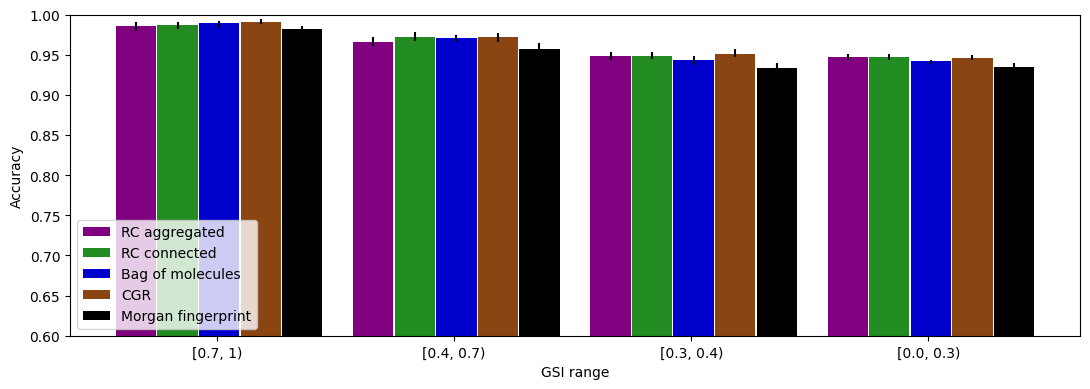

In [74]:
for strat in split_strategies:
    print(strat)
    x = [i for i in range(len(bins[strat]))]
    for metric_k, metric in discrete_metrics.items():
        print(metric_k)
        fig, ax = plt.subplots(figsize=figsize, sharey=True)
        for i, (lb, ub) in enumerate(bins[strat]):
            for _, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
                model_name = row['model/name']
                oid = row['Run ID']
                th = best_thresholds.get(oid, 0.5)
                pred = preds[oid]
                pred = pred.loc[(pred['max_sim'] < ub) & (pred['max_sim'] >= lb)]

                val, (lci, uci) = metric(pred['y'].to_numpy(), pred['logits'].to_numpy(), threshold=th)
                
                ci = np.array([val - lci, uci - val]).reshape(2, 1)

                ax.bar(x=x[i] - offset + width * bar_shifts[model_name] * space, height=val, yerr=ci, width=width, color=colors[model_name])
                print(model_name, val)
            
        for key in labels:
            ax.bar(0, 0, color=colors[key], label=labels[key])
        
        ax.set_ylim(*ylim[strat])
        ax.set_xticks(np.array(x) - width / 2)
        ax.set_xticklabels(bins2labels(bins[strat]))
        ax.set_ylabel(metric_names[metric_k])
        ax.set_xlabel(f"{similarity_names[strat]} range")
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.savefig(save_to / f"{strat}_similarity_clustered_{metric_names[metric_k]}.svg")
        plt.show()

In [ ]:
# best_thresholds = {
#     'ff90895a6070499b8fdcdc0982526885': 0.010101010101010102,
#     '8a155bc5673b4c6aa8667dd55755fe0b': 0.010101010101010102,
#     '5ca6ba7b8aec4b81a366e9138b9c09b0': 0.010101010101010102,
#     '2241478505f9497885d25b9a0dee3ffd': 0.15151515151515152,
#     'e638683b53f84d0ba1c8f32794413e0e': 0.12121212121212122,
#     'fb3c7a9061a744fba7dabf9d50092414': 0.010101010101010102,
#     '4bf93c6830744a4b8e6d8076f14a82e1': 0.05050505050505051,
#     'ef2ce94281fb445ba304791f991e23cc': 0.26262626262626265,
#     '3c1ce655b064442cb7789fa210e4caaf': 0.21212121212121213,
#     '2a7b803f790143f0b14a1955117cb393': 0.010101010101010102,
#     '84eab00d36354c1bac700bd82b9b222c': 0.25252525252525254,
#     'e48cb2b15ee94a3aae6e3b324d3d8aba': 0.17171717171717174,
#     'b1f3ce077f454c828d0837acbac7bb6e': 0.26262626262626265,
#     'd898b47a73984726bb593a3a19a6b2ec': 0.30303030303030304,
#     'f3bbad9576cd45f69569f7914c5a8b18': 0.37373737373737376,
#     'd618e5ac38c24e089a5c477dc8902f09': 0.010101010101010102,
#     '28ebdae603464197a6ac0ecb38469b6f': 0.010101010101010102,
#     '311eda1797af4cfaa2eb7067655a381b': 0.010101010101010102,
#     'be7e38c4676e4e5ebc3caf2adcd76ca7': 0.010101010101010102,
#     '36bb12690dda4298bccd1a8a63930e53': 0.030303030303030304,
#     'a9f2dce71dc041e0a76c1663b5d9b41d': 0.5757575757575758,
#     'f43941db95544e59a3e2b584b9aee567': 0.595959595959596,
#     '6576cf8c65be40c5a1573685f0727082': 0.14141414141414144,
#     '199d3b61c7c1450aa7176fb0735de21e': 0.494949494949495,
#     '1e871b45c8bc46fab2da4c233681be3a': 0.38383838383838387,
#     '36be3d0aca6d4b42804e6670437da7e4': 0.05050505050505051,
#     '412c8627a31b4ba7a40967d344ae4745': 0.05050505050505051,
#     '0d61a0f54d54424a82760f42bd4698ab': 0.010101010101010102,
#     '547968f96d9a45da91a9d5808fd5345c': 0.010101010101010102,
#     '3d30cac508c542b1b61590a45d6c687a': 0.04040404040404041
# }